# TB Analysis for Timor-Leste (2018-2023)

This notebook contains the statistical analysis for the tuberculosis incidence study in Timor-Leste, examining factors influencing TB evolution, country clustering patterns, trend analysis, and project justification.

## Phase 1: Variable Selection and Data Preparation

### Loading and preparing the Global TB Report data

In [1]:
# Load required libraries
library(tidyverse)

# Display loaded libraries
cat("Libraries loaded successfully!\n")
cat("Working directory:", getwd(), "\n")

# Create output directory if it doesn't exist
output_dir <- "output"
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
  cat("Created output directory:", output_dir, "\n")
} else {
  cat("Output directory already exists:", output_dir, "\n")
}

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Libraries loaded successfully!
Working directory: /Users/inigo/Documents/cursos/Data Science/master_viu/work/tb-analysis 
Output directory already exists: output 


In [2]:
# TB Global Report 2024 Data Processing
# This code processes the new WHO Global TB Report 2024 dataset

# Step 1: Load the CSV into a tibble
print("Loading Global TB Report 2024 dataset...")
tb_global_2024 <- read_delim("data/DATA Global TB Report 2024.csv", 
                            delim = ";", 
                            col_types = cols(
                              IND_NAME = col_character(),
                              DIM_GEO_NAME = col_character(),
                              IND_CODE = col_character(),
                              DIM_GEO_CODE = col_character(),
                              DIM_TIME_YEAR = col_integer(),
                              DIM_1_CODE = col_character(),
                              VALUE_NUMERIC = col_double(),
                              VALUE_STRING = col_double(),
                              VALUE_COMMENTS = col_character()
                            ))
                           

print(paste("Dataset loaded with", nrow(tb_global_2024), "rows and", ncol(tb_global_2024), "columns"))

# Step 2: Create data dictionary tibble with unique IND_NAME and IND_CODE pairs
print("Creating data dictionary...")
tb_global_2024_dictionary <- tb_global_2024 %>%
  select(IND_NAME, IND_CODE) %>%
  distinct() %>%
  arrange(IND_CODE) %>%
  mutate(across(IND_CODE, str_to_lower)) %>%
  select(IND_CODE, IND_NAME)

print(paste("Dictionary created with", nrow(tb_global_2024_dictionary), "unique indicators"))

# Step 3: Export dictionary as CSV to output folder
write_csv(tb_global_2024_dictionary, "output/tb_global_2024_data_dictionary.csv")
print("Dictionary exported to: output/tb_global_2024_data_dictionary.csv")

# Step 4: Continue with main tibble - Remove specified columns
print("Removing unnecessary columns...")
tb_global_2024_clean <- tb_global_2024 %>%
  select(-IND_NAME, -VALUE_COMMENTS, -VALUE_NUMERIC)

print(paste("Columns removed. Dataset now has", ncol(tb_global_2024_clean), "columns"))

# Step 5: Filter out rows with specific values in DIM_1_CODE
print("Filtering out age group and sex-specific rows...")
tb_global_2024_filtered <- tb_global_2024_clean %>%
  filter(!DIM_1_CODE %in% c('AGEGROUP_YEARS15-19', 'AGEGROUP_YEARS10-14', 'SEX_FMLE', 'SEX_MLE')) %>%
  filter(!str_detect(DIM_GEO_NAME, "Region"))

print(paste("Filtering complete. Dataset reduced from", nrow(tb_global_2024_clean), 
            "to", nrow(tb_global_2024_filtered), "rows"))

# Step 6: Pivot the tibble across the IND_CODE variable
print("Pivoting dataset across IND_CODE...")
tb_global_2024_pivoted <- tb_global_2024_filtered %>%
  select(-DIM_1_CODE) %>%  # Remove DIM_1_CODE as it's no longer needed after filtering
  pivot_wider(
    names_from = IND_CODE,
    values_from = VALUE_STRING,
    values_fn = mean  # In case of duplicates, take the mean
  ) %>%
  rename_with(str_to_lower) %>%
  rename(country = dim_geo_name, 
         iso3 = dim_geo_code, 
         year = dim_time_year)

print(paste("Pivoting complete. Dataset now has", nrow(tb_global_2024_pivoted), "rows and", 
            ncol(tb_global_2024_pivoted), "columns"))

# Step 7: Export the resulting tibble as CSV to output folder
write_csv(tb_global_2024_pivoted, "output/tb_global_2024_processed.csv")
print("Processed dataset exported to: output/tb_global_2024_processed.csv")

# Display summary information
print("=== PROCESSING SUMMARY ===")
print(paste("Original dataset:", nrow(tb_global_2024), "rows x", ncol(tb_global_2024), "columns"))
print(paste("Unique indicators:", nrow(tb_global_2024_dictionary)))
print(paste("Final processed dataset:", nrow(tb_global_2024_pivoted), "rows x", ncol(tb_global_2024_pivoted), "columns"))
print(paste("Countries/regions included:", length(unique(tb_global_2024_pivoted$dim_geo_name))))
print(paste("Years covered:", min(tb_global_2024_pivoted$dim_time_year, na.rm = TRUE), 
            "to", max(tb_global_2024_pivoted$dim_time_year, na.rm = TRUE)))

# Display first few rows of processed data
print("=== PREVIEW OF PROCESSED DATA ===")
glimpse(tb_global_2024_pivoted)

# Step 8: Data Quality Check for Timor-Leste (2015-2023)
print("=== TIMOR-LESTE DATA QUALITY CHECK ===")
timor_leste_check <- tb_global_2024_pivoted %>%
  filter(country == 'Timor-Leste', 
         year >= 2015 & year <= 2023)

print(paste("Timor-Leste data rows found:", nrow(timor_leste_check)))

if (nrow(timor_leste_check) > 0) {
  # Count non-missing values per column (excluding identifier columns)
  column_completeness <- timor_leste_check %>%
    select(-country, -iso3, -year) %>%  # Exclude identifier columns
    summarise(across(everything(), ~ sum(!is.na(.x)))) %>%
    pivot_longer(everything(), names_to = "column", values_to = "non_missing_count") %>%
    filter(non_missing_count >= 3) %>%
    arrange(desc(non_missing_count))
  
  print(paste("Columns with at least 3 non-missing values:", nrow(column_completeness)))
  
  # Display the results
  print("=== COLUMN COMPLETENESS SUMMARY ===")
  print(column_completeness)
  
  # Summary statistics
  indicator_columns <- ncol(timor_leste_check) - 3  # Total columns minus the 3 identifier columns
  print(paste("Total indicator columns checked:", indicator_columns))
  print(paste("Columns with sufficient data (>=3 values):", nrow(column_completeness)))
  print(paste("Data completeness rate:", round(nrow(column_completeness)/indicator_columns*100, 1), "%"))
  # Set a flag to indicate if the data is complete
  if (nrow(column_completeness) == 0) {tl_global_complete <- FALSE} else {tl_global_complete <- TRUE}
  
} else {
  print("No data found for Timor-Leste in the specified period")
}

[1] "Loading Global TB Report 2024 dataset..."


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


[1] "Dataset loaded with 10503 rows and 9 columns"
[1] "Creating data dictionary..."
[1] "Dictionary created with 60 unique indicators"
[1] "Dictionary exported to: output/tb_global_2024_data_dictionary.csv"
[1] "Removing unnecessary columns..."
[1] "Columns removed. Dataset now has 6 columns"
[1] "Filtering out age group and sex-specific rows..."
[1] "Filtering complete. Dataset reduced from 10503 to 8659 rows"
[1] "Pivoting dataset across IND_CODE..."
[1] "Pivoting complete. Dataset now has 1335 rows and 57 columns"
[1] "Processed dataset exported to: output/tb_global_2024_processed.csv"
[1] "=== PROCESSING SUMMARY ==="
[1] "Original dataset: 10503 rows x 9 columns"
[1] "Unique indicators: 60"
[1] "Final processed dataset: 1335 rows x 57 columns"


Warning message:
"Unknown or uninitialised column: `dim_geo_name`."


[1] "Countries/regions included: 0"


Warning message:
"Unknown or uninitialised column: `dim_time_year`."
Warning message in min(tb_global_2024_pivoted$dim_time_year, na.rm = TRUE):
"no non-missing arguments to min; returning Inf"
Warning message:
"Unknown or uninitialised column: `dim_time_year`."
Warning message in max(tb_global_2024_pivoted$dim_time_year, na.rm = TRUE):
"no non-missing arguments to max; returning -Inf"


[1] "Years covered: Inf to -Inf"
[1] "=== PREVIEW OF PROCESSED DATA ==="
Rows: 1,335
Columns: 57
$ country                           <chr> "Afghanistan", "Afghanistan", "Afgha~
$ iso3                              <chr> "AFG", "AFG", "AFG", "AFG", "AFG", "~
$ year                              <int> 2019, 2022, 2023, 2020, 2018, 2021, ~
$ sdgairboda                        <dbl> 265.7, NA, NA, NA, NA, NA, 92.5, NA,~
$ ncd_hyp_prevalence_a              <dbl> 40.2, NA, NA, NA, NA, NA, 41.8, NA, ~
$ ncd_bmi_30a                       <dbl> NA, 19.2, NA, NA, NA, NA, NA, 23.4, ~
$ m_est_tob_curr_std                <dbl> NA, 22.7, NA, NA, NA, NA, NA, 21.9, ~
$ sdgodaws                          <dbl> NA, 67.96, NA, NA, NA, NA, NA, 30.30~
$ sdgpm25                           <dbl> 75.2, NA, NA, NA, NA, NA, 16.6, NA, ~
$ sdgihr2021                        <dbl> NA, NA, 38, NA, NA, NA, NA, NA, 95, ~
$ hwf_0010                          <dbl> 0.7, NA, NA, NA, NA, NA, NA, NA, NA,~
$ hwf_0001             

### Loading and processing the TB datasets

In [3]:
# Define file paths for all TB datasets (excluding data dictionary)
data_files <- list(
  burden = "data/TB_burden_countries_2025-06-08.csv",
  budget = "data/TB_budget_2025-06-07.csv", 
  community = "data/TB_community_engagement_2025-06-07.csv",
  dr_surveillance = "data/TB_dr_surveillance_2025-06-08.csv",
  expenditure = "data/TB_expenditure_utilisation_2025-06-07.csv",
  notifications = "data/TB_notifications_2025-06-07.csv",
  policies = "data/TB_policies_services_2025-06-07.csv"
)

# Check if all files exist
file_check <- map_lgl(data_files, file.exists)
cat("File existence check:\n")
print(file_check)

if (!all(file_check)) {
  stop("Some data files are missing!")
} else {
  cat("\nAll data files found successfully!\n")
}


File existence check:
         burden          budget       community dr_surveillance     expenditure 
           TRUE            TRUE            TRUE            TRUE            TRUE 
  notifications        policies 
           TRUE            TRUE 

All data files found successfully!


In [4]:
# Function to load and add dataset source identifier
load_tb_dataset <- function(file_path, dataset_name) {
  cat("Loading:", dataset_name, "from", file_path, "\n")
  
  # Read the CSV file
  data <- read_csv(file_path, show_col_types = FALSE)
  
  # Add dataset source column
  data$dataset_source <- dataset_name
  
  # Print basic info
  cat("  Dimensions:", nrow(data), "rows x", ncol(data), "columns\n")
  cat("  Columns:", paste(names(data)[1:min(5, ncol(data))], collapse = ", "))
  if (ncol(data) > 5) cat(", ...")
  cat("\n\n")
  
  return(data)
}

# Load all datasets
tb_datasets <- map2(data_files, names(data_files), load_tb_dataset)


Loading: burden from data/TB_burden_countries_2025-06-08.csv 
  Dimensions: 5117 rows x 51 columns
  Columns: country, iso2, iso3, iso_numeric, g_whoregion, ...

Loading: budget from data/TB_budget_2025-06-07.csv 
  Dimensions: 1505 rows x 44 columns
  Columns: country, iso2, iso3, iso_numeric, g_whoregion, ...

Loading: community from data/TB_community_engagement_2025-06-07.csv 
  Dimensions: 999 rows x 23 columns
  Columns: country, iso2, iso3, iso_numeric, g_whoregion, ...

Loading: dr_surveillance from data/TB_dr_surveillance_2025-06-08.csv 
  Dimensions: 1505 rows x 54 columns
  Columns: country, iso2, iso3, iso_numeric, g_whoregion, ...

Loading: expenditure from data/TB_expenditure_utilisation_2025-06-07.csv 
  Dimensions: 1505 rows x 47 columns
  Columns: country, iso2, iso3, iso_numeric, g_whoregion, ...

Loading: notifications from data/TB_notifications_2025-06-07.csv 


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


  Dimensions: 9352 rows x 211 columns
  Columns: country, iso2, iso3, iso_numeric, g_whoregion, ...

Loading: policies from data/TB_policies_services_2025-06-07.csv 
  Dimensions: 215 rows x 36 columns
  Columns: country, iso2, iso3, iso_numeric, g_whoregion, ...



In [5]:
# Examine the structure of each dataset using tidyverse approach
cat("=== DATASET STRUCTURE ANALYSIS ===\n\n")

# Create a summary tibble for all datasets using purrr
dataset_summary <- tibble(
  dataset_name = names(tb_datasets),
  dataset_data = tb_datasets
) %>%
  mutate(
    nrows = map_int(dataset_data, nrow),
    ncols = map_int(dataset_data, ncol),
    common_cols = map(dataset_data, ~ intersect(names(.x), c("country", "year", "iso2", "iso3", "iso_numeric"))),
    first_10_cols = map(dataset_data, ~ names(.x)[1:min(10, ncol(.x))])
  )

# Display results using pwalk for formatted output
pwalk(list(dataset_summary$dataset_name, 
          dataset_summary$nrows, 
          dataset_summary$ncols,
          dataset_summary$common_cols,
          dataset_summary$first_10_cols), 
     function(name, rows, cols, common, first_cols) {
       cat("Dataset:", name, "\n")
       cat("Dimensions:", rows, "rows x", cols, "columns\n")
       cat("Common joining columns:", paste(common, collapse = ", "), "\n")
       cat("First 10 columns:", paste(first_cols, collapse = ", "), "\n")
       cat("---\n\n")
     })

=== DATASET STRUCTURE ANALYSIS ===

Dataset: burden 
Dimensions: 5117 rows x 51 columns
Common joining columns: country, iso2, iso3, iso_numeric, year 
First 10 columns: country, iso2, iso3, iso_numeric, g_whoregion, year, e_pop_num, e_inc_100k, e_inc_100k_lo, e_inc_100k_hi 
---

Dataset: budget 
Dimensions: 1505 rows x 44 columns
Common joining columns: country, iso2, iso3, iso_numeric, year 
First 10 columns: country, iso2, iso3, iso_numeric, g_whoregion, year, tx_dstb, budget_cpp_dstb, tx_mdr, budget_cpp_mdr 
---

Dataset: community 
Dimensions: 999 rows x 23 columns
Common joining columns: country, iso2, iso3, iso_numeric, year 
First 10 columns: country, iso2, iso3, iso_numeric, g_whoregion, year, bmu, bmu_community_impl, community_data_available, bmu_ref_data 
---

Dataset: dr_surveillance 
Dimensions: 1505 rows x 54 columns
Common joining columns: country, iso2, iso3, iso_numeric, year 
First 10 columns: country, iso2, iso3, iso_numeric, g_whoregion, year, pulm_labconf_new, pulm

In [6]:
# Function to standardize joining columns and combine datasets using functional programming
combine_tb_datasets <- function(dataset_list) {
  
  # Start with the first dataset as base
  base_data <- dataset_list[[1]]
  cat("Starting with", names(dataset_list)[1], "as base dataset\n")
  cat("Base dimensions:", nrow(base_data), "rows x", ncol(base_data), "columns\n\n")
  
  # Use reduce to sequentially join all datasets
  combined_data <- reduce2(
    .x = dataset_list[-1],  # All datasets except the first
    .y = names(dataset_list)[-1],  # Corresponding names
    .init = base_data,
    .f = function(combined, next_dataset, dataset_name) {
      
      cat("Joining", dataset_name, "...\n")
      cat("  Dataset dimensions:", nrow(next_dataset), "rows x", ncol(next_dataset), "columns\n")
      
      # Identify common columns for joining using vectorized operations
      possible_join_cols <- c("country", "year", "iso3")
      join_cols <- possible_join_cols[
        possible_join_cols %in% names(combined) & 
        possible_join_cols %in% names(next_dataset)
      ]
      
      cat("  Joining on columns:", paste(join_cols, collapse = ", "), "\n")
      
      # Perform full join to preserve all data
      if (length(join_cols) > 0) {
        result <- full_join(combined, next_dataset, by = join_cols)
      } else {
        cat("  WARNING: No common columns found, using cbind (risky!)\n")
        result <- cbind(combined, next_dataset)
      }
      
      cat("  Combined dimensions:", nrow(result), "rows x", ncol(result), "columns\n\n")
      return(result)
    }
  )
  
  return(combined_data)
}

# Combine all datasets
cat("=== COMBINING ALL TB DATASETS ===\n\n")
tb_combined <- combine_tb_datasets(tb_datasets)

# Final step: Join the new Global TB Report 2024 data with the existing combined dataset
if (tl_global_complete) {
  print("Joining Global TB Report 2024 data with existing combined dataset...")
  tb_combined <- tb_combined %>%
    full_join(tb_global_2024_pivoted, by = c("country", "year", "iso3"))

  print(paste("Final combined dataset dimensions:", nrow(tb_combined), "rows x", ncol(tb_combined), "columns"))
}


=== COMBINING ALL TB DATASETS ===

Starting with burden as base dataset
Base dimensions: 5117 rows x 51 columns

Joining budget ...
  Dataset dimensions: 1505 rows x 44 columns
  Joining on columns: country, year, iso3 
  Combined dimensions: 5332 rows x 92 columns

Joining community ...
  Dataset dimensions: 999 rows x 23 columns
  Joining on columns: country, year, iso3 
  Combined dimensions: 5332 rows x 112 columns

Joining dr_surveillance ...
  Dataset dimensions: 1505 rows x 54 columns
  Joining on columns: country, year, iso3 
  Combined dimensions: 5332 rows x 163 columns

Joining expenditure ...
  Dataset dimensions: 1505 rows x 47 columns
  Joining on columns: country, year, iso3 
  Combined dimensions: 5332 rows x 207 columns

Joining notifications ...
  Dataset dimensions: 9352 rows x 211 columns
  Joining on columns: country, year, iso3 
  Combined dimensions: 9567 rows x 415 columns

Joining policies ...
  Dataset dimensions: 215 rows x 36 columns
  Joining on columns: co

In [7]:
# Remove duplicate columns that may have been created during joining
cat("=== REMOVING DUPLICATE COLUMNS ===\n\n")

# Function to identify and remove duplicate columns
remove_duplicate_columns <- function(data) {
  original_ncol <- ncol(data)
  original_names <- names(data)
  
  cat("Original dataset dimensions:", nrow(data), "rows x", original_ncol, "columns\n")
  
  # Identify duplicate column names
  duplicate_names <- original_names[duplicated(original_names)]
  
  if (length(duplicate_names) > 0) {
    cat("Found duplicate column names:", paste(duplicate_names, collapse = ", "), "\n")
    
    # Keep only the first occurrence of each column name
    data <- data[, !duplicated(names(data))]
    
    cat("After removing duplicates:", nrow(data), "rows x", ncol(data), "columns\n")
    cat("Removed", original_ncol - ncol(data), "duplicate columns\n")
  } else {
    cat("No duplicate column names found\n")
  }
  
  # Also check for columns with identical content (but different names)
  # This is more computationally intensive, so we'll just flag potential issues
  if (ncol(data) > 50) {
    cat("Dataset has many columns (", ncol(data), "), skipping content-based duplicate detection\n")
  } else {
    cat("Checking for content-based duplicates...\n")
    # Convert to character for comparison to handle different data types
    data_char <- data %>% mutate(across(everything(), as.character))
    
    # Find columns with identical content using functional approach
    # Create all pairs of column indices to compare
    col_indices <- seq_len(ncol(data_char))
    col_pairs <- expand.grid(i = col_indices, j = col_indices) %>%
      filter(i < j)  # Only compare each pair once
    
    # Check for identical content using map2
    content_duplicates <- col_pairs %>%
      mutate(
        col_i = names(data_char)[i],
        col_j = names(data_char)[j],
        identical_content = map2_lgl(i, j, ~ identical(data_char[[.x]], data_char[[.y]]))
      ) %>%
      filter(identical_content) %>%
      pull(col_j)
    
    if (length(content_duplicates) > 0) {
      cat("Found columns with identical content:", paste(content_duplicates, collapse = ", "), "\n")
      cat("Consider reviewing these manually\n")
    } else {
      cat("No content-based duplicates found\n")
    }
  }
  
  return(data)
}

# Apply duplicate removal
tb_final <- remove_duplicate_columns(tb_combined)


=== REMOVING DUPLICATE COLUMNS ===

Original dataset dimensions: 9567 rows x 448 columns
No duplicate column names found
Dataset has many columns ( 448 ), skipping content-based duplicate detection


In [8]:
# Final dataset summary and basic exploration
cat("=== FINAL COMBINED DATASET SUMMARY ===\n\n")

cat("Final dimensions:", nrow(tb_final), "rows x", ncol(tb_final), "columns\n\n")

# Show basic structure
cat("Column names (first 20):\n")
print(names(tb_final)[1:min(20, ncol(tb_final))])

if (ncol(tb_final) > 20) {
  cat("\n... and", ncol(tb_final) - 20, "more columns\n")
}

# Check for key columns we'll need for analysis
key_columns <- c("country", "year", "iso3", "g_whoregion", 
                "e_inc_100k", "e_mort_100k", "c_cdr", "c_newinc",
                "budget_tot", "exp_tot")

cat("\n=== KEY COLUMNS CHECK ===\n")
# Check key columns using vectorized operations
key_columns_check <- tibble(column = key_columns) %>%
  mutate(
    present = column %in% names(tb_final),
    non_na_count = map_int(column, ~ if(.x %in% names(tb_final)) sum(!is.na(tb_final[[.x]])) else 0)
  )

# Display results using walk
walk(1:nrow(key_columns_check), function(i) {
  col <- key_columns_check$column[i]
  present <- key_columns_check$present[i]
  count <- key_columns_check$non_na_count[i]
  
  if (present) {
    cat("*", col, "- Present (", count, "non-NA values)\n")
  } else {
    cat("*", col, "- Missing\n")
  }
})

# Show year range
if ("year" %in% names(tb_final)) {
  year_range <- range(tb_final$year, na.rm = TRUE)
  cat("\nYear range:", year_range[1], "to", year_range[2], "\n")
}

# Show number of countries
if ("country" %in% names(tb_final)) {
  n_countries <- length(unique(tb_final$country[!is.na(tb_final$country)]))
  cat("Number of countries:", n_countries, "\n")
}

# Check for Timor-Leste specifically
if ("country" %in% names(tb_final)) {
  timor_data <- tb_final[grep("Timor", tb_final$country, ignore.case = TRUE), ]
  if (nrow(timor_data) > 0) {
    cat("\nTimor-Leste data found:", nrow(timor_data), "rows\n")
    cat("Timor-Leste country name in data:", unique(timor_data$country), "\n")
  } else {
    cat("\nWARNING: No Timor-Leste data found\n")
  }
}

cat("\n=== DATA LOADING COMPLETE ===\n")
cat("Combined dataset saved as 'tb_final'\n")


=== FINAL COMBINED DATASET SUMMARY ===

Final dimensions: 9567 rows x 448 columns

Column names (first 20):
 [1] "country"             "iso2.x"              "iso3"               
 [4] "iso_numeric.x"       "g_whoregion.x"       "year"               
 [7] "e_pop_num"           "e_inc_100k"          "e_inc_100k_lo"      
[10] "e_inc_100k_hi"       "e_inc_num"           "e_inc_num_lo"       
[13] "e_inc_num_hi"        "e_tbhiv_prct"        "e_tbhiv_prct_lo"    
[16] "e_tbhiv_prct_hi"     "e_inc_tbhiv_100k"    "e_inc_tbhiv_100k_lo"
[19] "e_inc_tbhiv_100k_hi" "e_inc_tbhiv_num"    

... and 428 more columns

=== KEY COLUMNS CHECK ===
* country - Present ( 9567 non-NA values)
* year - Present ( 9567 non-NA values)
* iso3 - Present ( 9567 non-NA values)
* g_whoregion - Present ( 215 non-NA values)
* e_inc_100k - Present ( 5117 non-NA values)
* e_mort_100k - Present ( 5093 non-NA values)
* c_cdr - Present ( 4822 non-NA values)
* c_newinc - Present ( 8793 non-NA values)
* budget_tot - Present ( 

### Data Filtering and Export

Before proceeding to the main analysis, we need to filter the data to focus on the project period (2015-2023) and export the final dataset.


In [9]:
# Filter data to focus on project period (2015-2023)
cat("=== FILTERING DATA FOR PROJECT PERIOD (2015-2023) ===\n\n")

# Check current year distribution
cat("Original year distribution:\n")
year_counts <- table(tb_final$year, useNA = "ifany")
print(year_counts)

cat("\nTotal rows before filtering:", nrow(tb_final), "\n")

# Filter for years 2015-2023
tb_filtered <- tb_final %>% 
  filter(year >= 2015 & year <= 2023)

cat("Total rows after filtering:", nrow(tb_filtered), "\n")

# Show filtered year distribution
cat("\nFiltered year distribution:\n")
filtered_year_counts <- table(tb_filtered$year, useNA = "ifany")
print(filtered_year_counts)

# Check Timor-Leste data in filtered dataset
timor_filtered <- tb_filtered %>% 
  filter(country == "Timor-Leste")

cat("\nTimor-Leste data in filtered dataset:\n")
cat("Rows:", nrow(timor_filtered), "\n")
if (nrow(timor_filtered) > 0) {
  cat("Years available:", paste(sort(unique(timor_filtered$year)), collapse = ", "), "\n")
}


=== FILTERING DATA FOR PROJECT PERIOD (2015-2023) ===

Original year distribution:

1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 
 211  211  211  211  211  211  211  211  211  211  211  211  211  211  211  211 
1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 
 211  211  211  211  211  211  212  212  212  213  213  213  213  213  214  215 
2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024 
 215  215  215  215  215  215  215  215  215  215  215  215  215 

Total rows before filtering: 9567 
Total rows after filtering: 1935 

Filtered year distribution:

2015 2016 2017 2018 2019 2020 2021 2022 2023 
 215  215  215  215  215  215  215  215  215 

Timor-Leste data in filtered dataset:
Rows: 9 
Years available: 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023 


In [10]:
# Remove columns with insufficient data for Timor-Leste (fewer than 3 non-NA values)
# This captures columns that are completely missing, have only 1 non-NA value, or have only 2 non-NA values
cat("=== REMOVING COLUMNS WITH fewer than 3 non-NA values for Timor-Leste ===\n\n")

# Filter for Timor-Leste data to check which columns have any data
timor_data <- tb_filtered %>% 
  filter(country == "Timor-Leste")

if (nrow(timor_data) > 0) {
  # Identify columns with insufficient data using vectorized operations
  timor_missing_cols <- timor_data %>%
    summarise(across(everything(), ~ sum(!is.na(.x)))) %>%
    pivot_longer(cols = everything(), names_to = "column", values_to = "non_na_count") %>%
    filter(non_na_count < 3) %>%
    pull(column)
  
  cat("Original dataset columns:", ncol(tb_filtered), "\n")
  cat("Columns with fewer than 3 non-NA values for Timor-Leste:", length(timor_missing_cols), "\n")
  
  if (length(timor_missing_cols) > 0) {
    # Show first few examples
    cat("Examples of columns to remove:", paste(head(timor_missing_cols, 10), collapse = ", "))
    if (length(timor_missing_cols) > 10) {
      cat(", ... and", length(timor_missing_cols) - 10, "more")
    }
    cat("\n\n")
    
    # Remove these columns from the entire dataset
    tb_filtered_clean <- tb_filtered %>% 
      select(-all_of(timor_missing_cols))
    
    cat("After removing columns with insufficient Timor-Leste data:", ncol(tb_filtered_clean), "columns\n")
    cat("Removed", length(timor_missing_cols), "columns with fewer than 3 non-NA values\n")
    
    # Update the filtered dataset
    tb_filtered <- tb_filtered_clean
    
  } else {
    cat("No columns found with fewer than 3 non-NA values for Timor-Leste\n")
  }
  
  # Verify Timor-Leste data availability after cleaning
  timor_clean <- tb_filtered %>% 
    filter(country == "Timor-Leste")
  
  # Count non-missing columns for Timor-Leste using vectorized operations
  timor_data_cols <- timor_clean %>%
    summarise(across(everything(), ~ !all(is.na(.x)))) %>%
    pivot_longer(cols = everything(), names_to = "column", values_to = "has_data") %>%
    summarise(count = sum(has_data)) %>%
    pull(count)
  
  cat("\nTimor-Leste data verification after cleaning:\n")
  cat("Total columns:", ncol(timor_clean), "\n")
  cat("Columns with at least some Timor-Leste data:", timor_data_cols, "\n")
  cat("Columns with fewer than 3 non-NA values for Timor-Leste:", ncol(timor_clean) - timor_data_cols, "\n")
  
} else {
  cat("WARNING: No Timor-Leste data found for cleaning!\n")
}


=== REMOVING COLUMNS WITH fewer than 3 non-NA values for Timor-Leste ===

Original dataset columns: 448 
Columns with fewer than 3 non-NA values for Timor-Leste: 197 
Examples of columns to remove: community_nsp, community_prog_review, community_annual_report, community_manuals, community_budget_available, cf_community, r_rlt_rel, rr_rel, rr_hivunk, nrr_hivpos, ... and 187 more

After removing columns with insufficient Timor-Leste data: 251 columns
Removed 197 columns with fewer than 3 non-NA values

Timor-Leste data verification after cleaning:
Total columns: 251 
Columns with at least some Timor-Leste data: 251 
Columns with fewer than 3 non-NA values for Timor-Leste: 0 


### Variable Documentation and Focus Selection

Before proceeding with exploratory analysis, we need to document our variables and select the most relevant ones for focused analysis.


In [11]:
# Clean up variable names by removing join suffixes
cat("=== CLEANING UP VARIABLE NAMES ===\n\n")

# Show current variable names with suffixes
suffix_vars <- names(tb_filtered)[grepl("\\.(x|y)", names(tb_filtered))]
cat("Variables with join suffixes found:", length(suffix_vars), "\n")
if (length(suffix_vars) > 0) {
  cat("Examples:", paste(head(suffix_vars, 10), collapse = ", "), "\n\n")
}

# Step 1: Remove variables with complex suffixes (.x.x.x, .y.y.y, .x.x, .y.y, .y)
vars_to_remove <- names(tb_filtered)[grepl("\\.(x\\.x\\.x|y\\.y\\.y|x\\.x|y\\.y|y)$", names(tb_filtered))]

cat("Removing variables with complex suffixes:\n")
cat("Variables to remove:", length(vars_to_remove), "\n")
if (length(vars_to_remove) > 0) {
  cat("Examples:", paste(head(vars_to_remove, 8), collapse = ", "), "\n")
  
  # Remove these variables
  tb_filtered_clean <- tb_filtered %>%
    select(-all_of(vars_to_remove))
  
  cat("Dataset after removing complex suffixes:", ncol(tb_filtered_clean), "columns\n\n")
} else {
  tb_filtered_clean <- tb_filtered
  cat("No variables with complex suffixes found\n\n")
}

# Step 2: Rename variables ending in '.x' to remove the suffix
vars_with_x <- names(tb_filtered_clean)[grepl("\\.x$", names(tb_filtered_clean))]

cat("Renaming variables ending in '.x':\n")
cat("Variables to rename:", length(vars_with_x), "\n")
if (length(vars_with_x) > 0) {
  cat("Examples:", paste(head(vars_with_x, 8), collapse = ", "), "\n")
  
  # Create new names without .x suffix
  new_names <- names(tb_filtered_clean)
  new_names[grepl("\\.x$", new_names)] <- gsub("\\.x$", "", new_names[grepl("\\.x$", new_names)])
  
  # Apply new names
  names(tb_filtered_clean) <- new_names
  
  cat("Sample renamed variables:\n")
  renamed_examples <- data.frame(
    original = head(vars_with_x, 5),
    renamed = head(gsub("\\.x$", "", vars_with_x), 5)
  )
  print(renamed_examples)
} else {
  cat("No variables ending in '.x' found\n")
}

# Update the main dataset
tb_filtered <- tb_filtered_clean

cat("\nFinal dataset after cleaning:\n")
cat("Dimensions:", nrow(tb_filtered), "rows x", ncol(tb_filtered), "columns\n")
cat("Variables with suffixes remaining:", sum(grepl("\\.(x|y)", names(tb_filtered))), "\n")


=== CLEANING UP VARIABLE NAMES ===

Variables with join suffixes found: 24 
Examples: iso2.x, iso_numeric.x, g_whoregion.x, dataset_source.x, iso2.y, iso_numeric.y, g_whoregion.y, dataset_source.y, iso2.x.x, iso_numeric.x.x 

Removing variables with complex suffixes:
Variables to remove: 20 
Examples: iso2.y, iso_numeric.y, g_whoregion.y, dataset_source.y, iso2.x.x, iso_numeric.x.x, g_whoregion.x.x, dataset_source.x.x 
Dataset after removing complex suffixes: 231 columns

Renaming variables ending in '.x':
Variables to rename: 4 
Examples: iso2.x, iso_numeric.x, g_whoregion.x, dataset_source.x 
Sample renamed variables:
          original        renamed
1           iso2.x           iso2
2    iso_numeric.x    iso_numeric
3    g_whoregion.x    g_whoregion
4 dataset_source.x dataset_source

Final dataset after cleaning:
Dimensions: 1935 rows x 231 columns
Variables with suffixes remaining: 0 


In [12]:
# Summary of filtered dataset for analysis readiness
cat("=== FILTERED DATASET SUMMARY FOR ANALYSIS ===\n\n")

# Key statistics for the filtered dataset
cat("Dataset period: 2015-2023\n")
cat("Total observations:", nrow(tb_filtered), "\n")
cat("Total variables:", ncol(tb_filtered), "\n")
cat("Countries included:", length(unique(tb_filtered$country)), "\n")

# Check data availability for key variables in the filtered period
key_vars_analysis <- c("e_inc_100k", "e_mort_100k", "c_cdr", "c_newinc", 
                      "budget_tot", "exp_tot", "newrel_hivtest", "conf_rrmdr")

cat("\nKey variables data availability (2015-2023):\n")
# Create a summary of key variables availability using dplyr
key_vars_summary <- tibble(variable = key_vars_analysis) %>%
  mutate(
    exists = map_lgl(variable, ~ .x %in% names(tb_filtered)),
    available = map_int(variable, ~ if(.x %in% names(tb_filtered)) sum(!is.na(tb_filtered[[.x]])) else 0),
    percentage = round((available / nrow(tb_filtered)) * 100, 1)
  )

# Display results using pwalk
pwalk(list(key_vars_summary$variable, key_vars_summary$exists, 
          key_vars_summary$available, key_vars_summary$percentage),
     function(var, exists, avail, pct) {
       if (exists) {
         cat(" ", var, ":", avail, "observations (", pct, "%)\n")
       } else {
         cat(" ", var, ": Variable not found\n")
       }
     })

# Timor-Leste readiness check
cat("\nTimor-Leste analysis readiness:\n")
if (nrow(timor_filtered) > 0) {
  timor_years <- sort(unique(timor_filtered$year))
  cat("Years available:", paste(timor_years, collapse = ", "), "\n")
  
  # Check key variables for Timor-Leste using vectorized approach
  timor_key_vars <- c("e_inc_100k", "c_cdr", "budget_tot")
  timor_vars_summary <- tibble(variable = timor_key_vars) %>%
    filter(variable %in% names(timor_filtered)) %>%
    mutate(
      non_na_count = map_int(variable, ~ sum(!is.na(timor_filtered[[.x]])))
    )
  
  # Display results
  walk2(timor_vars_summary$variable, timor_vars_summary$non_na_count,
       ~ cat(" ", .x, ":", .y, "non-NA values\n"))
} else {
  cat("WARNING: No Timor-Leste data in filtered period!\n")
}


=== FILTERED DATASET SUMMARY FOR ANALYSIS ===

Dataset period: 2015-2023
Total observations: 1935 
Total variables: 231 
Countries included: 215 

Key variables data availability (2015-2023):
  e_inc_100k : 1935 observations ( 100 %)
  e_mort_100k : 1926 observations ( 99.5 %)
  c_cdr : 1839 observations ( 95 %)
  c_newinc : 1881 observations ( 97.2 %)
  budget_tot : 829 observations ( 42.8 %)
  exp_tot : 931 observations ( 48.1 %)
  newrel_hivtest : 1685 observations ( 87.1 %)
  conf_rrmdr : 988 observations ( 51.1 %)

Timor-Leste analysis readiness:
Years available: 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023 
  e_inc_100k : 9 non-NA values
  c_cdr : 9 non-NA values
  budget_tot : 6 non-NA values


In [13]:
# Re-export the cleaned dataset
cat("=== EXPORTING CLEANED DATASET ===\n\n")

# Export the cleaned and filtered dataset
output_file_clean <- file.path("output", "tb_combined_2015_2023_clean.csv")

cat("Exporting cleaned dataset to:", output_file_clean, "\n")
write_csv(tb_filtered, output_file_clean)

# Verify the export
if (file.exists(output_file_clean)) {
  file_size <- file.size(output_file_clean)
  cat("Export successful!\n")
  cat("File size:", round(file_size / (1024^2), 2), "MB\n")
  
  # Quick verification
  verification <- read_csv(output_file_clean, n_max = 3, show_col_types = FALSE)
  cat("Verification dimensions:", nrow(verification), "rows x", ncol(verification), "columns\n")
  
  # Check if variable names are clean
  suffix_check <- sum(grepl("\\.(x|y)", names(verification)))
  cat("Variables with suffixes in exported file:", suffix_check, "\n")
} else {
  cat("Export failed!\n")
}

cat("\n=== DATASET CLEANING AND EXPORT COMPLETE ===\n")


=== EXPORTING CLEANED DATASET ===

Exporting cleaned dataset to: output/tb_combined_2015_2023_clean.csv 
Export successful!
File size: 1.53 MB
Verification dimensions: 3 rows x 231 columns
Variables with suffixes in exported file: 0 

=== DATASET CLEANING AND EXPORT COMPLETE ===


In [14]:
# Load the data dictionary to get variable descriptions
cat("=== LOADING DATA DICTIONARY FOR VARIABLE DOCUMENTATION ===\n\n")

# Read the data dictionary
data_dict <- read_csv("data/TB_data_dictionary_2025-06-12.csv", show_col_types = FALSE)

cat("Data dictionary dimensions:", nrow(data_dict), "rows x", ncol(data_dict), "columns\n")
cat("Dictionary columns:", paste(names(data_dict), collapse = ", "), "\n\n")

# Show first few entries
cat("Sample dictionary entries:\n")
print(head(data_dict, 5))

# Get the variable names from our final filtered dataset
final_variables <- names(tb_filtered)
cat("\nFinal dataset variables:", length(final_variables), "\n")

# Create a comprehensive variable documentation using joins instead of loops
variable_docs <- tibble(
  variable_name = final_variables,
  in_dictionary = variable_name %in% data_dict$variable_name
) %>%
  left_join(
    data_dict %>% 
      select(variable_name, definition, dataset, code_list) %>%
      # Handle potential duplicates by taking first occurrence
      group_by(variable_name) %>%
      slice(1) %>%
      ungroup(),
    by = "variable_name"
  ) %>%
  rename(
    description = definition,
    dataset_source = dataset
  )

cat("\nVariable documentation matching results:\n")
cat("Variables found in dictionary:", sum(variable_docs$in_dictionary), "\n")
cat("Variables not in dictionary:", sum(!variable_docs$in_dictionary), "\n")


=== LOADING DATA DICTIONARY FOR VARIABLE DOCUMENTATION ===

Data dictionary dimensions: 688 rows x 4 columns
Dictionary columns: variable_name, dataset, code_list, definition 

Sample dictionary entries:
# A tibble: 5 x 4
  variable_name   dataset code_list definition                                  
  <chr>           <chr>   <chr>     <chr>                                       
1 budget_cpp_dstb Budget  NA        Average cost of drugs budgeted per patient ~
2 budget_cpp_mdr  Budget  NA        Average cost of drugs budgeted per patient ~
3 budget_cpp_tpt  Budget  NA        Average cost of drugs budgeted per patient ~
4 budget_cpp_xdr  Budget  NA        Average cost of drugs budgeted per patient ~
5 budget_fld      Budget  NA        Budget required for drugs to treat drug-sus~

Final dataset variables: 231 

Variable documentation matching results:
Variables found in dictionary: 229 
Variables not in dictionary: 2 


In [15]:
# Handle variables not in dictionary (often due to suffixes like .x, .y from joins)
cat("=== HANDLING VARIABLES NOT IN DICTIONARY ===\n\n")

# Check variables not found in dictionary
missing_vars <- variable_docs[!variable_docs$in_dictionary, ]
cat("Variables not found in dictionary:\n")
print(head(missing_vars$variable_name, 10))

# Try to match variables with suffixes (.x, .y) to original names using vectorized operations
missing_var_indices <- which(!variable_docs$in_dictionary)
if (length(missing_var_indices) > 0) {
  suffix_matches <- variable_docs[missing_var_indices, ] %>%
    mutate(
      clean_name = gsub("\\.x$|\\.y$", "", variable_name),
      name_changed = clean_name != variable_name,
      in_dict = clean_name %in% data_dict$variable_name,
      can_match = name_changed & in_dict
    )
  
  # Process matches using left_join
  matched_vars <- suffix_matches %>%
    filter(can_match) %>%
    left_join(
      data_dict %>% 
        select(variable_name, definition, dataset, code_list) %>%
        rename(clean_name = variable_name),
      by = "clean_name"
    ) %>%
    mutate(
      description = paste0(definition, " [joined variable]"),
      dataset_source = dataset,
      in_dictionary = TRUE
    )
  
  # Update the original dataframe for matched variables
  if (nrow(matched_vars) > 0) {
    match_indices <- missing_var_indices[suffix_matches$can_match]
    variable_docs$description[match_indices] <- matched_vars$description
    variable_docs$dataset_source[match_indices] <- matched_vars$dataset_source  
    variable_docs$code_list[match_indices] <- matched_vars$code_list
    variable_docs$in_dictionary[match_indices] <- TRUE
  }
}

# Add manual descriptions for key variables that might be missing
manual_descriptions <- list(
  "dataset_source" = "Source dataset identifier added during data combination",
  "country" = "Country name",
  "year" = "Calendar year",
  "iso2" = "ISO 2-letter country code",
  "iso3" = "ISO 3-letter country code", 
  "iso_numeric" = "ISO numeric country code"
)

# Apply manual descriptions using vectorized operations
manual_desc_df <- tibble(
  variable_name = names(manual_descriptions),
  manual_desc = unlist(manual_descriptions),
  manual_source = "Multiple/Common"
)

# Update variable_docs for variables that need manual descriptions
variable_docs <- variable_docs %>%
  left_join(manual_desc_df, by = "variable_name") %>%
  mutate(
    description = coalesce(description, manual_desc),
    dataset_source = coalesce(dataset_source, manual_source)
  ) %>%
  select(-manual_desc, -manual_source)

cat("\nAfter cleaning and manual additions:\n")
cat("Variables with descriptions:", sum(!is.na(variable_docs$description)), "\n")
cat("Variables still missing descriptions:", sum(is.na(variable_docs$description)), "\n")


=== HANDLING VARIABLES NOT IN DICTIONARY ===

Variables not found in dictionary:
[1] "year"           "dataset_source"

After cleaning and manual additions:
Variables with descriptions: 231 
Variables still missing descriptions: 0 


In [16]:
# Export variable documentation to CSV
cat("=== EXPORTING VARIABLE DOCUMENTATION ===\n\n")

# Create final variable documentation dataframe
variable_documentation <- variable_docs %>%
  select(variable_name, description, dataset_source, code_list) %>%
  arrange(variable_name)

# Export to CSV
var_doc_file <- file.path("output", "tb_variables_documentation.csv")
write_csv(variable_documentation, var_doc_file)

cat("Variable documentation exported to:", var_doc_file, "\n")
cat("Documentation contains:", nrow(variable_documentation), "variables\n")

# Show sample of documented variables
cat("\nSample of variable documentation:\n")
print(head(variable_documentation[!is.na(variable_documentation$description), ], 8))

# Verify export
if (file.exists(var_doc_file)) {
  file_size <- file.size(var_doc_file)
  cat("\nExport successful! File size:", round(file_size / 1024, 1), "KB\n")
} else {
  cat("\nExport failed!\n")
}


=== EXPORTING VARIABLE DOCUMENTATION ===

Variable documentation exported to: output/tb_variables_documentation.csv 
Documentation contains: 231 variables

Sample of variable documentation:
# A tibble: 8 x 4
  variable_name          description                    dataset_source code_list
  <chr>                  <chr>                          <chr>          <chr>    
1 agegroup_option        The set of age groups by whic~ Notification   220=all ~
2 all_conf_xdr           Number of laboratory-confirme~ Notification   NA       
3 bmu                    Number of TB Basic Management~ Community eng~ NA       
4 bmu_community_impl     Number of TB Basic Management~ Community eng~ NA       
5 bmu_ref_data           Number of Basic Management Un~ Community eng~ NA       
6 bmu_rxsupport_data     Number of Basic Management Un~ Community eng~ NA       
7 bmu_rxsupport_data_coh Total number of patients who ~ Community eng~ NA       
8 budget_cpp_dstb        Average cost of drugs budgete~ Budget 

In [17]:
# Export tb_filtered dataset with variable descriptions as second row
cat("=== EXPORTING TB_FILTERED WITH VARIABLE DESCRIPTIONS ===\n\n")

# Create a descriptions row that matches the order of columns in tb_filtered
variable_names <- names(tb_filtered)
descriptions_row <- character(length(variable_names))

cat("Matching", length(variable_names), "variables with their descriptions...\n")

# Match variables with descriptions using vectorized operations
descriptions_lookup <- tibble(variable_name = variable_names) %>%
  left_join(
    variable_documentation %>% 
      select(variable_name, description),
    by = "variable_name"
  ) %>%
  mutate(
    description = coalesce(
      description, 
      paste("[No description available for", variable_name, "]")
    )
  )

descriptions_row <- descriptions_lookup$description

cat("Descriptions matched for", sum(descriptions_row != "" & !grepl("\\[No description available", descriptions_row)), "variables\n")
cat("Missing descriptions for", sum(grepl("\\[No description available", descriptions_row)), "variables\n\n")

# Create the enhanced dataset with descriptions
cat("Creating dataset with description row...\n")

# First, create a data frame with the description row
descriptions_df <- as.data.frame(t(descriptions_row), stringsAsFactors = FALSE)
names(descriptions_df) <- variable_names

# Combine descriptions row with the actual data
tb_with_descriptions <- rbind(descriptions_df, tb_filtered)

cat("Enhanced dataset dimensions:", nrow(tb_with_descriptions), "rows x", ncol(tb_with_descriptions), "columns\n")
cat("(Includes 1 description row + ", nrow(tb_filtered), " data rows)\n\n")

# Export the enhanced dataset
enhanced_file <- file.path("output", "tb_filtered_2015_2023_with_descriptions.csv")
cat("Exporting to:", enhanced_file, "\n")

write_csv(tb_with_descriptions, enhanced_file)

# Verify the export
if (file.exists(enhanced_file)) {
  file_size <- round(file.size(enhanced_file) / (1024^2), 2)
  cat("Export successful!\n")
  cat("File size:", file_size, "MB\n")
  
  # Quick verification - read first 3 rows to check format
  verification <- read_csv(enhanced_file, n_max = 3, show_col_types = FALSE)
  cat("Verification - first 3 rows (1 description + 2 data rows):\n")
  cat("Dimensions:", nrow(verification), "rows x", ncol(verification), "columns\n")
  
  # Show a sample of the description row for verification
  cat("\nSample variable descriptions (first 3 columns):\n")
  # Create sample verification using tidyverse
  sample_descriptions <- verification[1, ] %>%  # First row contains descriptions
    select(1:min(3, ncol(verification))) %>%
    pivot_longer(cols = everything(), names_to = "col_name", values_to = "description")
  
  # Display using walk2
  walk2(sample_descriptions$col_name, sample_descriptions$description,
       ~ cat("  -", .x, ":", substr(as.character(.y), 1, 60), "...\n"))
  
} else {
  cat("Export failed!\n")
}

cat("\n=== ENHANCED EXPORT COMPLETE ===\n")
cat("The CSV file now contains:\n")
cat("  - Row 1: Variable names (headers)\n") 
cat("  - Row 2: Variable descriptions from WHO data dictionary\n")
cat("  - Rows 3+: Actual data (", nrow(tb_filtered), "observations)\n")
cat("  - Total columns:", ncol(tb_filtered), "\n")
cat("  - Period: 2015-2023\n")

=== EXPORTING TB_FILTERED WITH VARIABLE DESCRIPTIONS ===

Matching 231 variables with their descriptions...
Descriptions matched for 231 variables
Missing descriptions for 0 variables

Creating dataset with description row...
Enhanced dataset dimensions: 1936 rows x 231 columns
(Includes 1 description row +  1935  data rows)

Exporting to: output/tb_filtered_2015_2023_with_descriptions.csv 
Export successful!
File size: 1.55 MB
Verification - first 3 rows (1 description + 2 data rows):
Dimensions: 3 rows x 231 columns

Sample variable descriptions (first 3 columns):
  - country : Country or territory name ...
  - iso2 : ISO 2-character country/territory code ...
  - iso3 : ISO 3-character country/territory code ...

=== ENHANCED EXPORT COMPLETE ===
The CSV file now contains:
  - Row 1: Variable names (headers)
  - Row 2: Variable descriptions from WHO data dictionary
  - Rows 3+: Actual data ( 1935 observations)
  - Total columns: 231 
  - Period: 2015-2023


In [18]:
# Identify the most relevant variables for focused analysis (using only available variables)
cat("=== SELECTING MOST RELEVANT VARIABLES FOR FOCUSED ANALYSIS ===\n\n")

# Define categories of most relevant variables based on research questions
# All variables listed below are confirmed to be available in tb_variables_documentation.csv
key_variables <- list(
  
  # PRIMARY OUTCOME VARIABLES (TB Incidence & Mortality)
  primary_outcomes = c(
    "e_inc_100k",          # Estimated incidence (all forms) per 100,000 population
    "e_mort_100k",         # Estimated mortality per 100,000 population  
    "e_inc_num"            # Estimated number of incident cases (all forms)
  ),
  
  # CASE DETECTION & SURVEILLANCE
  case_detection = c(
    "c_cdr",               # Case detection rate (treatment coverage), percent
    "c_newinc",            # Total of new and relapse cases
    "c_newinc_100k"        # Case notification rate per 100,000 population
  ),
  
  # FINANCIAL & RESOURCE ALLOCATION
  financial = c(
    "budget_tot",          # Total budget required (US Dollars)
    "exp_tot",             # Total actual expenditure (US Dollars)
    "rcvd_tot_domestic"    # Funding received from domestic sources (US Dollars)
  ),
  
  # COMMUNITY ENGAGEMENT & OUTREACH
  community_engagement = c(
    "bmu",                 # Number of TB Basic Management Units in the country
    "bmu_community_impl",  # BMUs implementing community-based referrals/treatment support
    "bmu_ref_data",        # BMUs with data on referrals by community health workers
    "community_data_available" # Community data availability indicator
  ),
  
  # TREATMENT & OUTCOMES
  treatment_outcomes = c(
    "newrel_hivtest",      # New and relapse cases tested for HIV
    "succ_coh",            # Treatment success rate for cohort
    "coh"                  # Cohort size for treatment outcome evaluation
  ),
  
  # DRUG RESISTANCE & SURVEILLANCE
  drug_resistance = c(
    "conf_rrmdr",          # Laboratory-confirmed rifampicin-resistant/MDR-TB cases
    "rr_new",              # New cases with rifampicin resistance
    "mdr"                  # MDR-TB cases
  ),
  
  # POLICIES & HEALTH SYSTEM
  policies_services = c(
    "caseb_err_nat",       # Case-based surveillance error at national level
    "hcw_tb_infected",     # Healthcare workers infected with TB
    "ident_pris"           # TB identification in prisons/detention facilities
  ),
  
  # GEOGRAPHIC & TEMPORAL IDENTIFIERS
  identifiers = c(
    "country",             # Country name
    "year",                # Calendar year
    "g_whoregion",         # WHO region
    "iso3"                 # ISO 3-letter country code
  )
)

# Combine all key variables
all_key_vars <- unlist(key_variables, use.names = FALSE)

cat("Selected key variables by category (all available in dataset):\n")
# Create a comprehensive variable summary using functional programming
variable_summary <- tibble(
  category = rep(names(key_variables), lengths(key_variables)),
  variable = unlist(key_variables, use.names = FALSE)
) %>%
  left_join(
    variable_documentation %>% 
      select(variable_name, description),
    by = c("variable" = "variable_name")
  ) %>%
  mutate(
    description = coalesce(description, "[Description not available]"),
    description_short = substr(description, 1, 80)
  ) %>%
  arrange(category, variable)

# Display results grouped by category using group_walk
variable_summary %>%
  group_by(category) %>%
  group_walk(~ {
    cat("\n", toupper(.y$category), ":\n")
    walk2(.x$variable, .x$description_short,
         ~ cat("  -", .x, ":", .y, "\n"))
  })

cat("\nSUMMARY OF FOCUSED VARIABLE SELECTION:\n")
cat("Total recommended variables for focused analysis:", length(all_key_vars), "\n")
cat("All variables confirmed available in dataset:", length(all_key_vars), "\n")
cat("Variables by category:\n")
# Create category counts using functional programming
category_counts <- tibble(
  category = names(key_variables),
  vars_total = lengths(key_variables)
)

# Display using walk2
walk2(category_counts$category, category_counts$vars_total,
     ~ cat("  -", .x, ":", .y, "variables\n"))


=== SELECTING MOST RELEVANT VARIABLES FOR FOCUSED ANALYSIS ===

Selected key variables by category (all available in dataset):

 CASE_DETECTION :
  - c_cdr : Case detection rate (all forms) [also known as TB treatment coverage], percent 
  - c_newinc : Total of new and relapse cases and cases with unknown previous TB treatment hist 
  - c_newinc_100k : Case notification rate, which is the total of new and relapse cases and cases wi 

 COMMUNITY_ENGAGEMENT :
  - bmu : Number of TB Basic Management Units in the country 
  - bmu_community_impl : Number of TB Basic Management Units which implemented community-based referrals  
  - bmu_ref_data : Number of Basic Management Units with data on referrals by community health work 
  - community_data_available : Are data available on community-based referrals or any form of community treatme 

 DRUG_RESISTANCE :
  - conf_rrmdr : Number of laboratory-confirmed RR-TB or MDR-TB cases identified 
  - mdr : [Description not available] 
  - rr_new : N

In [19]:
# Create focused dataset with key variables and validate data availability
cat("=== CREATING FOCUSED DATASET FOR ANALYSIS ===\n\n")

# Check which key variables exist in our dataset
available_key_vars <- all_key_vars[all_key_vars %in% names(tb_filtered)]
missing_key_vars <- all_key_vars[!all_key_vars %in% names(tb_filtered)]

cat("Available key variables:", length(available_key_vars), "\n")
if (length(missing_key_vars) > 0) {
  cat("Missing key variables:", length(missing_key_vars), "\n")
  cat("Missing:", paste(missing_key_vars, collapse = ", "), "\n\n")
}

# Create focused dataset
tb_focused <- tb_filtered %>%
  select(all_of(available_key_vars))

cat("Focused dataset dimensions:", nrow(tb_focused), "rows x", ncol(tb_focused), "columns\n\n")

# Check data availability for each key variable using vectorized operations
cat("Data availability for key variables:\n")
data_availability <- tb_focused %>%
  summarise(across(everything(), ~ sum(!is.na(.x)))) %>%
  pivot_longer(cols = everything(), names_to = "variable", values_to = "non_na_obs") %>%
  mutate(
    total_obs = nrow(tb_focused),
    percentage = round((non_na_obs / total_obs) * 100, 1)
  )

# Display results using walk
walk(1:nrow(data_availability), function(i) {
  var <- data_availability$variable[i]
  non_na <- data_availability$non_na_obs[i]
  total <- data_availability$total_obs[i]
  pct <- data_availability$percentage[i]
  cat("  -", var, ":", non_na, "/", total, "(", pct, "%)\n")
})

# Check Timor-Leste data availability for key variables
cat("\nTimor-Leste data availability for key variables:\n")
timor_focused <- tb_focused %>% filter(country == "Timor-Leste")

if (nrow(timor_focused) > 0) {
  # Calculate Timor-Leste data availability using vectorized operations
  timor_availability <- timor_focused %>%
    summarise(across(everything(), ~ sum(!is.na(.x)))) %>%
    pivot_longer(cols = everything(), names_to = "variable", values_to = "timor_non_na") %>%
    mutate(timor_obs = nrow(timor_focused))
  
  # Display results using walk
  walk(1:nrow(timor_availability), function(i) {
    var <- timor_availability$variable[i]
    non_na <- timor_availability$timor_non_na[i]
    obs <- timor_availability$timor_obs[i]
    cat("  -", var, ":", non_na, "/", obs, "years available\n")
  })
} else {
  cat("  WARNING: No Timor-Leste data found!\n")
}

cat("\n=== FOCUSED VARIABLE SELECTION COMPLETE ===\n")
cat("Ready for exploratory analysis with", ncol(tb_focused), "key variables\n")


=== CREATING FOCUSED DATASET FOR ANALYSIS ===

Available key variables: 20 
Missing key variables: 6 
Missing: succ_coh, coh, mdr, caseb_err_nat, hcw_tb_infected, ident_pris 

Focused dataset dimensions: 1935 rows x 20 columns

Data availability for key variables:
  - e_inc_100k : 1935 / 1935 ( 100 %)
  - e_mort_100k : 1926 / 1935 ( 99.5 %)
  - e_inc_num : 1935 / 1935 ( 100 %)
  - c_cdr : 1839 / 1935 ( 95 %)
  - c_newinc : 1881 / 1935 ( 97.2 %)
  - c_newinc_100k : 1881 / 1935 ( 97.2 %)
  - budget_tot : 829 / 1935 ( 42.8 %)
  - exp_tot : 931 / 1935 ( 48.1 %)
  - rcvd_tot_domestic : 678 / 1935 ( 35 %)
  - bmu : 851 / 1935 ( 44 %)
  - bmu_community_impl : 808 / 1935 ( 41.8 %)
  - bmu_ref_data : 528 / 1935 ( 27.3 %)
  - community_data_available : 858 / 1935 ( 44.3 %)
  - newrel_hivtest : 1685 / 1935 ( 87.1 %)
  - conf_rrmdr : 988 / 1935 ( 51.1 %)
  - rr_new : 1361 / 1935 ( 70.3 %)
  - country : 1935 / 1935 ( 100 %)
  - year : 1935 / 1935 ( 100 %)
  - g_whoregion : 1935 / 1935 ( 100 %)
  - 

In [20]:
# Export focused datasets and documentation before Phase 2
cat("=== EXPORTING FOCUSED DATASETS AND DOCUMENTATION ===\n\n")

# 1. Export the focused dataset (tb_focused) with 19 key variables
cat("1. Exporting focused dataset (tb_focused)...\n")
focused_file <- file.path("output", "tb_focused_variables_2015_2023.csv")
write_csv(tb_focused, focused_file)

if (file.exists(focused_file)) {
  file_size <- round(file.size(focused_file) / 1024, 1)
  cat("   Export successful: tb_focused_variables_2015_2023.csv\n")
  cat("   Dimensions:", nrow(tb_focused), "rows x", ncol(tb_focused), "columns\n")
  cat("   File size:", file_size, "KB\n\n")
} else {
  cat("   Export failed!\n\n")
}

# 2. Export Timor-Leste focused dataset
cat("2. Exporting Timor-Leste focused dataset...\n")
timor_file <- file.path("output", "timor_leste_focused_2015_2023.csv")
write_csv(timor_focused, timor_file)

if (file.exists(timor_file)) {
  file_size <- round(file.size(timor_file) / 1024, 1)
  cat("   Export successful: timor_leste_focused_2015_2023.csv\n")
  cat("   Dimensions:", nrow(timor_focused), "rows x", ncol(timor_focused), "columns\n")
  cat("   File size:", file_size, "KB\n\n")
} else {
  cat("   Export failed!\n\n")
}

# 3. Create and export focused variable documentation for the 19 available variables
cat("3. Creating focused variable documentation...\n")

# Get only the variables that are actually present in tb_focused dataset
available_focused_vars <- names(tb_focused)

# Create category mapping for available variables only
focused_var_docs <- data.frame(
  variable_name = available_focused_vars,
  stringsAsFactors = FALSE
)

# Add category information using vectorized operations
category_mapping <- stack(key_variables) %>%
  rename(variable_name = values, category = ind)

focused_var_docs <- focused_var_docs %>%
  left_join(category_mapping, by = "variable_name")

# Add descriptions using left_join instead of loops
focused_var_docs <- focused_var_docs %>%
  left_join(
    variable_documentation %>% 
      select(variable_name, description, dataset_source),
    by = "variable_name"
  ) %>%
  mutate(
    description = coalesce(description, "[Description not found in dictionary]"),
    dataset_source = coalesce(dataset_source, "Unknown")
  )

# Reorder columns for better presentation
focused_var_docs <- focused_var_docs[, c("category", "variable_name", "description", "dataset_source")]

# Export focused variable documentation
focused_docs_file <- file.path("output", "tb_focused_variables_documentation.csv")
write_csv(focused_var_docs, focused_docs_file)

if (file.exists(focused_docs_file)) {
  file_size <- round(file.size(focused_docs_file) / 1024, 1)
  cat("   Export successful: tb_focused_variables_documentation.csv\n")
  cat("   Variables documented:", nrow(focused_var_docs), "available variables\n")
  cat("   File size:", file_size, "KB\n\n")
} else {
  cat("   Export failed!\n\n")
}

# Display summary of focused documentation
cat("=== FOCUSED VARIABLE DOCUMENTATION SUMMARY ===\n")
cat("Variables by category (available only):\n")
# Create category summary using dplyr
category_summary <- focused_var_docs %>%
  filter(!is.na(category)) %>%
  count(category, name = "n_vars") %>%
  arrange(category)

# Display using walk2
walk2(category_summary$category, category_summary$n_vars,
     ~ cat("  *", .x, ":", .y, "variables\n"))

# Count missing variables from original selection
cat("\nMissing variables from original 23-variable selection:\n")
all_planned_vars <- unlist(key_variables, use.names = FALSE)
missing_vars <- all_planned_vars[!all_planned_vars %in% names(tb_focused)]
if (length(missing_vars) > 0) {
  # Create missing vars summary using vectorized operations
  missing_vars_summary <- tibble(variable = missing_vars) %>%
    left_join(category_mapping, by = c("variable" = "variable_name")) %>%
    mutate(category = coalesce(category, "unknown"))
  
  # Display results using walk2
  walk2(missing_vars_summary$variable, missing_vars_summary$category,
       ~ cat("  *", .x, "(", .y, ")\n"))
} else {
  cat("  • None - all planned variables available!\n")
}

cat("\n=== EXPORT SUMMARY ===\n")
cat("Files created in output/ directory:\n")
cat("1. tb_focused_variables_2015_2023.csv - Focused dataset (", nrow(tb_focused), "rows x", ncol(tb_focused), "cols)\n")
cat("2. timor_leste_focused_2015_2023.csv - Timor-Leste data (", nrow(timor_focused), "rows x", ncol(timor_focused), "cols)\n")
cat("3. tb_focused_variables_documentation.csv - Variable documentation (", nrow(focused_var_docs), "variables)\n")
cat("\nAll exports completed successfully!\n")
cat("Ready to proceed with Phase 2: Exploratory Data Analysis\n")


=== EXPORTING FOCUSED DATASETS AND DOCUMENTATION ===

1. Exporting focused dataset (tb_focused)...
   Export successful: tb_focused_variables_2015_2023.csv
   Dimensions: 1935 rows x 20 columns
   File size: 160.6 KB

2. Exporting Timor-Leste focused dataset...
   Export successful: timor_leste_focused_2015_2023.csv
   Dimensions: 9 rows x 20 columns
   File size: 1 KB

3. Creating focused variable documentation...
   Export successful: tb_focused_variables_documentation.csv
   Variables documented: 20 available variables
   File size: 2.3 KB

=== FOCUSED VARIABLE DOCUMENTATION SUMMARY ===
Variables by category (available only):
  * 1 : 3 variables
  * 2 : 3 variables
  * 3 : 3 variables
  * 4 : 4 variables
  * 5 : 1 variables
  * 6 : 2 variables
  * 8 : 4 variables

Missing variables from original 23-variable selection:
  * succ_coh ( treatment_outcomes )
  * coh ( treatment_outcomes )
  * mdr ( drug_resistance )
  * caseb_err_nat ( policies_services )
  * hcw_tb_infected ( policies_s

In [21]:
# Export tb_filtered dataset with variable descriptions as second row
cat("=== EXPORTING TB_FOCUSED WITH VARIABLE DESCRIPTIONS ===\n\n")

# Create a descriptions row that matches the order of columns in tb_filtered
variable_names <- names(tb_focused)
descriptions_row <- character(length(variable_names))

cat("Matching", length(variable_names), "variables with their descriptions...\n")

# Match variables with descriptions using vectorized operations
descriptions_lookup <- tibble(variable_name = variable_names) %>%
  left_join(
    variable_documentation %>% 
      select(variable_name, description),
    by = "variable_name"
  ) %>%
  mutate(
    description = coalesce(
      description, 
      paste("[No description available for", variable_name, "]")
    )
  )

descriptions_row <- descriptions_lookup$description

cat("Descriptions matched for", sum(descriptions_row != "" & !grepl("\\[No description available", descriptions_row)), "variables\n")
cat("Missing descriptions for", sum(grepl("\\[No description available", descriptions_row)), "variables\n\n")

# Create the enhanced dataset with descriptions
cat("Creating dataset with description row...\n")

# First, create a data frame with the description row
descriptions_df <- as.data.frame(t(descriptions_row), stringsAsFactors = FALSE)
names(descriptions_df) <- variable_names

# Combine descriptions row with the actual data
tb_with_descriptions <- rbind(descriptions_df, tb_focused)

cat("Enhanced dataset dimensions:", nrow(tb_with_descriptions), "rows x", ncol(tb_with_descriptions), "columns\n")
cat("(Includes 1 description row + ", nrow(tb_focused), " data rows)\n\n")

# Export the enhanced dataset
enhanced_file <- file.path("output", "tb_focused_2015_2023_with_descriptions.csv")
cat("Exporting to:", enhanced_file, "\n")

write_csv(tb_with_descriptions, enhanced_file)

# Verify the export
if (file.exists(enhanced_file)) {
  file_size <- round(file.size(enhanced_file) / (1024^2), 2)
  cat("Export successful!\n")
  cat("File size:", file_size, "MB\n")
  
  # Quick verification - read first 3 rows to check format
  verification <- read_csv(enhanced_file, n_max = 3, show_col_types = FALSE)
  cat("Verification - first 3 rows (1 description + 2 data rows):\n")
  cat("Dimensions:", nrow(verification), "rows x", ncol(verification), "columns\n")
  
  # Show a sample of the description row for verification
  cat("\nSample variable descriptions (first 3 columns):\n")
  # Create sample verification using tidyverse
  sample_descriptions <- verification[1, ] %>%  # First row contains descriptions
    select(1:min(3, ncol(verification))) %>%
    pivot_longer(cols = everything(), names_to = "col_name", values_to = "description")
  
  # Display using walk2
  walk2(sample_descriptions$col_name, sample_descriptions$description,
       ~ cat("  -", .x, ":", substr(as.character(.y), 1, 60), "...\n"))
  
} else {
  cat("Export failed!\n")
}

cat("\n=== ENHANCED EXPORT COMPLETE ===\n")
cat("The CSV file now contains:\n")
cat("  - Row 1: Variable names (headers)\n") 
cat("  - Row 2: Variable descriptions from WHO data dictionary\n")
cat("  - Rows 3+: Actual data (", nrow(tb_focused), "observations)\n")
cat("  - Total columns:", ncol(tb_focused), "\n")
cat("  - Period: 2015-2023\n")


=== EXPORTING TB_FOCUSED WITH VARIABLE DESCRIPTIONS ===

Matching 20 variables with their descriptions...
Descriptions matched for 20 variables
Missing descriptions for 0 variables

Creating dataset with description row...
Enhanced dataset dimensions: 1936 rows x 20 columns
(Includes 1 description row +  1935  data rows)

Exporting to: output/tb_focused_2015_2023_with_descriptions.csv 
Export successful!
File size: 0.16 MB
Verification - first 3 rows (1 description + 2 data rows):
Dimensions: 3 rows x 20 columns

Sample variable descriptions (first 3 columns):
  - e_inc_100k : Estimated incidence (all forms) per 100 000 population ...
  - e_mort_100k : Estimated mortality of TB cases (all forms) per 100 000 popu ...
  - e_inc_num : Estimated number of incident cases (all forms) ...

=== ENHANCED EXPORT COMPLETE ===
The CSV file now contains:
  - Row 1: Variable names (headers)
  - Row 2: Variable descriptions from WHO data dictionary
  - Rows 3+: Actual data ( 1935 observations)
  - To

## Phase 2

### 2.1 Descriptive analysis

In [22]:
# Load required libraries
library(tidyverse)
library(scales)      # For better axis formatting


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




TB Incidence Evolution by WHO Region (2015-2023)

Loading clean TB dataset...

Timeline data summary:
# A tibble: 6 x 4
  g_whoregion years_available avg_incidence countries
  <chr>       <chr>                   <dbl>     <dbl>
1 AFR         2015-2023               223.         47
2 AMR         2015-2023                28.3        45
3 EMR         2015-2023                64.9        22
4 EUR         2015-2023                25.8        54
5 SEA         2015-2023               257.         11
6 WPR         2015-2023               128.         36


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."



Plot saved as: output/tb_incidence_timeline_by_region.png


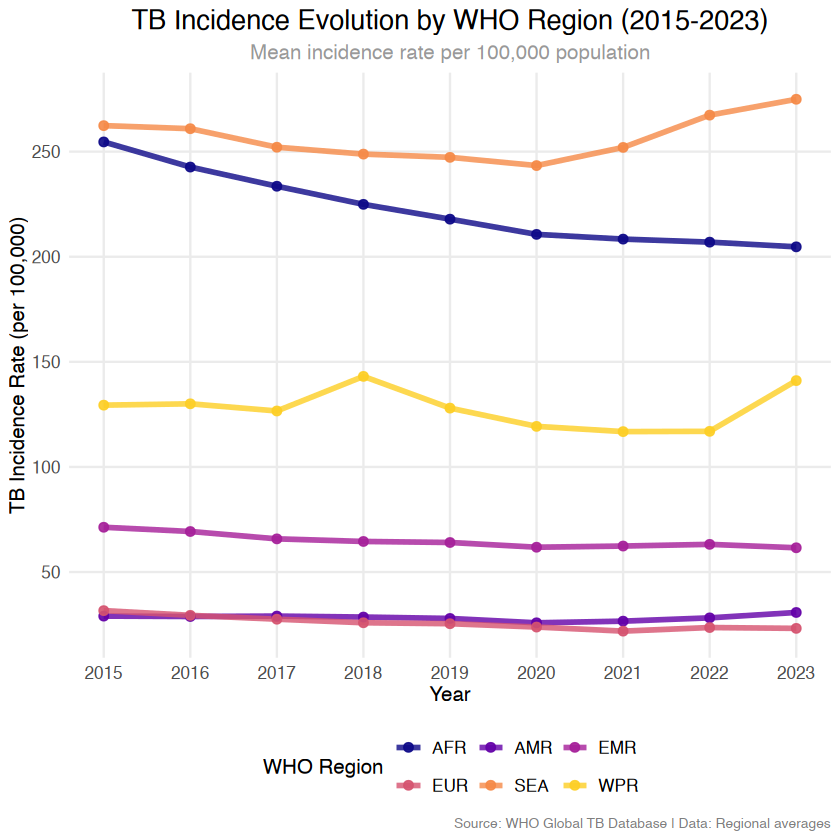

In [23]:
# Load the clean combined dataset
cat("Loading clean TB dataset...\n")
tb_data <- read_csv("output/tb_combined_2015_2023_clean.csv", show_col_types = FALSE)

# Prepare data for the timeline plot
tb_incidence_timeline <- tb_data %>%
  # Filter for complete cases of key variables
  filter(!is.na(e_inc_100k), !is.na(g_whoregion), !is.na(year)) %>%
  # Calculate regional averages by year
  group_by(g_whoregion, year) %>%
  summarise(
    mean_incidence = mean(e_inc_100k, na.rm = TRUE),
    median_incidence = median(e_inc_100k, na.rm = TRUE),
    countries_count = n(),
    .groups = "drop"
  ) %>%
  # Ensure year is numeric for proper timeline
  mutate(year = as.numeric(year))

# Display data summary
cat("\nTimeline data summary:\n")
print(tb_incidence_timeline %>% 
      group_by(g_whoregion) %>% 
      summarise(
        years_available = paste(range(year), collapse = "-"),
        avg_incidence = round(mean(mean_incidence), 1),
        countries = round(mean(countries_count), 0),
        .groups = "drop"
      ))

# Create the timeline multi-line plot
tb_timeline_plot <- tb_incidence_timeline %>%
  ggplot(aes(x = year, y = mean_incidence, color = g_whoregion)) +
  geom_line(size = 1.2, alpha = 0.8) +
  geom_point(size = 2, alpha = 0.9) +
  
  # Enhance the plot appearance
  scale_x_continuous(
    breaks = seq(2015, 2023, 1),
    labels = seq(2015, 2023, 1)
  ) +
  scale_y_continuous(
    labels = comma_format(),
    breaks = pretty_breaks(n = 8)
  ) +
  scale_color_viridis_d(
    name = "WHO Region",
    option = "plasma",
    end = 0.9
  ) +
  
  # Add labels and title
  labs(
    title = "TB Incidence Evolution by WHO Region (2015-2023)",
    subtitle = "Mean incidence rate per 100,000 population",
    x = "Year",
    y = "TB Incidence Rate (per 100,000)",
    caption = "Source: WHO Global TB Database | Data: Regional averages"
  ) +
  
  # Apply clean theme
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 12, hjust = 0.5, color = "gray60"),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 10),
    legend.title = element_text(size = 12, face = "bold"),
    legend.text = element_text(size = 10),
    legend.position = "bottom",
    panel.grid.minor = element_blank(),
    plot.caption = element_text(size = 8, color = "gray50")
  ) +
  guides(color = guide_legend(nrow = 2, byrow = TRUE))

# Display the plot
print(tb_timeline_plot)

# Optional: Save the plot
ggsave("output/tb_incidence_timeline_by_region.png", 
       plot = tb_timeline_plot,
       width = 12, height = 8, dpi = 300, bg = "white")

cat("\nPlot saved as: output/tb_incidence_timeline_by_region.png\n")

TB Incidence: Regional Trends vs Country Variations (2015-2023)

Timor-Leste data found: 9 observations
WHO Region: SEA 
Years available: 2015-2023 
Incidence range: 498 498 


Detailed plot with Timor-Leste highlighted saved as: output/tb_incidence_detailed_timeline_timor_highlighted.png


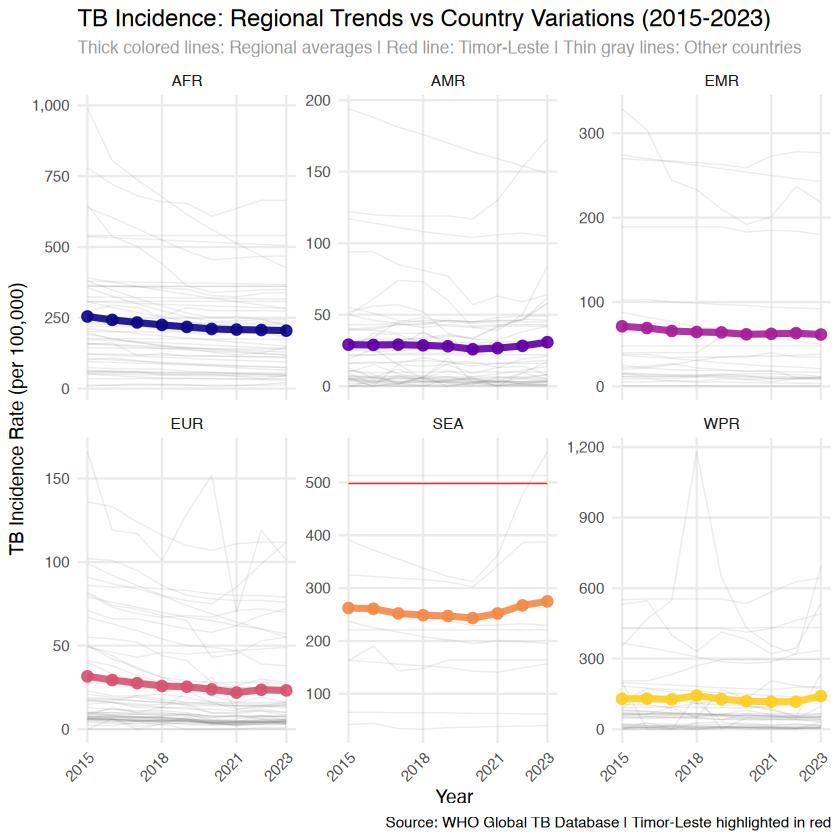

In [24]:
# Alternative plot: Show country trajectories with regional trend overlay
# HIGHLIGHTING TIMOR-LESTE (same thickness, color only)
tb_country_timeline <- tb_data %>%
  filter(!is.na(e_inc_100k), !is.na(g_whoregion), !is.na(year)) %>%
  mutate(year = as.numeric(year))

# Separate Timor-Leste data for highlighting
timor_leste_data <- tb_country_timeline %>%
  filter(country == "Timor-Leste")

# Check if Timor-Leste data exists
if(nrow(timor_leste_data) > 0) {
  cat("Timor-Leste data found:", nrow(timor_leste_data), "observations\n")
  cat("WHO Region:", unique(timor_leste_data$g_whoregion), "\n")
  cat("Years available:", paste(range(timor_leste_data$year), collapse = "-"), "\n")
  cat("Incidence range:", round(range(timor_leste_data$e_inc_100k, na.rm = TRUE), 1), "\n\n")
} else {
  cat("Warning: No data found for Timor-Leste\n")
}

# Plot with individual countries (gray lines), regional averages (colored lines), 
# and Timor-Leste highlighted in red
tb_detailed_plot <- tb_country_timeline %>%
  ggplot(aes(x = year, y = e_inc_100k)) +
  
  # Individual country trajectories (subtle background)
  geom_line(aes(group = country), 
            alpha = 0.15, color = "gray50", size = 0.3) +
  
  # HIGHLIGHT TIMOR-LESTE with red color only (same thickness)
  geom_line(data = timor_leste_data,
            aes(group = country), 
            color = "#E31A1C", size = 0.3, alpha = 0.9) +
  
  # Regional average trend (prominent)
  geom_line(data = tb_incidence_timeline,
            aes(y = mean_incidence, color = g_whoregion), 
            size = 1.5, alpha = 0.9) +
  
  # Regional average points
  geom_point(data = tb_incidence_timeline,
             aes(y = mean_incidence, color = g_whoregion), 
             size = 2.5, alpha = 0.9) +
  
  facet_wrap(~g_whoregion, scales = "free_y", ncol = 3) +
  
  scale_x_continuous(breaks = c(2015, 2018, 2021, 2023)) +
  scale_y_continuous(labels = comma_format()) +
  scale_color_viridis_d(option = "plasma", end = 0.9) +
  
  labs(
    title = "TB Incidence: Regional Trends vs Country Variations (2015-2023)",
    subtitle = "Thick colored lines: Regional averages | Red line: Timor-Leste | Thin gray lines: Other countries",
    x = "Year",
    y = "TB Incidence Rate (per 100,000)",
    caption = "Source: WHO Global TB Database | Timor-Leste highlighted in red"
  ) +
  
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 10, color = "gray60"),
    strip.text = element_text(size = 9, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "none",
    panel.grid.minor = element_blank()
  )

print(tb_detailed_plot)

# Save the detailed plot with Timor-Leste highlighted
ggsave("output/tb_incidence_detailed_timeline_timor_highlighted.png", 
       plot = tb_detailed_plot,
       width = 14, height = 10, dpi = 300, bg = "white")

cat("\nDetailed plot with Timor-Leste highlighted saved as: output/tb_incidence_detailed_timeline_timor_highlighted.png\n")

Global TB Incidence vs Mortality Evolution (2015-2023)

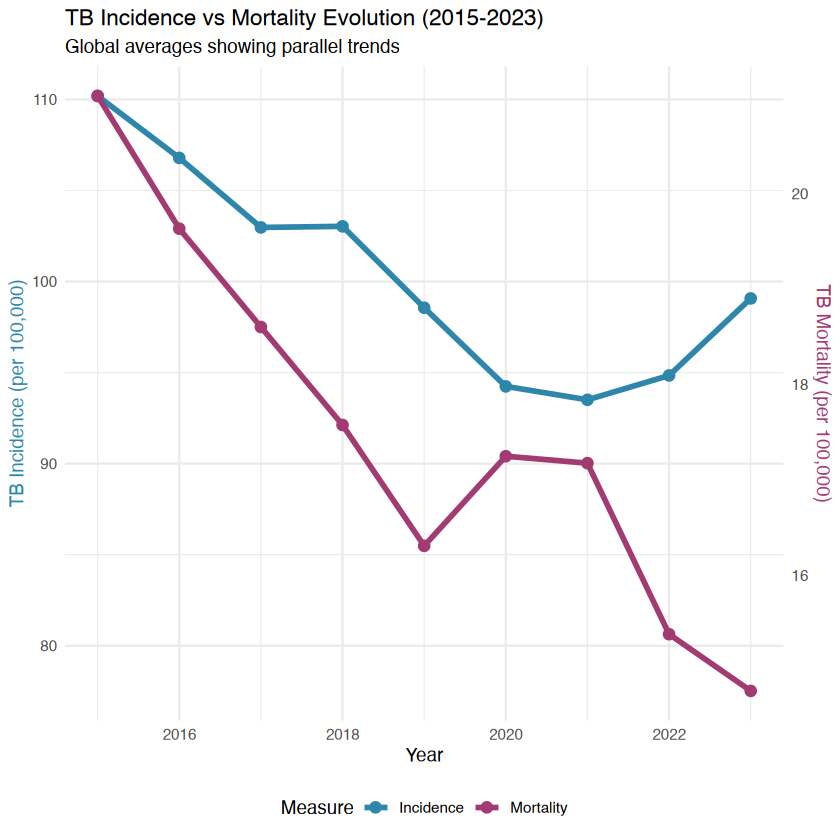

In [25]:
# Prepare data for dual-axis plot
tb_dual_data <- tb_data %>%
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(year)) %>%
  group_by(year) %>%
  summarise(
    mean_incidence = mean(e_inc_100k, na.rm = TRUE),
    mean_mortality = mean(e_mort_100k, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(year = as.numeric(year))

# Calculate scaling factor for dual axis
scale_factor <- max(tb_dual_data$mean_incidence, na.rm = TRUE) / 
                max(tb_dual_data$mean_mortality, na.rm = TRUE)

dual_axis_plot <- tb_dual_data %>%
  ggplot(aes(x = year)) +
  geom_line(aes(y = mean_incidence, color = "Incidence"), size = 1.2) +
  geom_point(aes(y = mean_incidence, color = "Incidence"), size = 2.5) +
  
  geom_line(aes(y = mean_mortality * scale_factor, color = "Mortality"), size = 1.2) +
  geom_point(aes(y = mean_mortality * scale_factor, color = "Mortality"), size = 2.5) +
  
  scale_y_continuous(
    name = "TB Incidence (per 100,000)",
    sec.axis = sec_axis(~ . / scale_factor, name = "TB Mortality (per 100,000)")
  ) +
  scale_color_manual(
    name = "Measure",
    values = c("Incidence" = "#2E86AB", "Mortality" = "#A23B72")
  ) +
  labs(
    title = "TB Incidence vs Mortality Evolution (2015-2023)",
    subtitle = "Global averages showing parallel trends",
    x = "Year"
  ) +
  theme_minimal() +
  theme(
    legend.position = "bottom",
    axis.title.y.left = element_text(color = "#2E86AB"),
    axis.title.y.right = element_text(color = "#A23B72")
  )

print(dual_axis_plot)

Global TB Case Fatality Rate Evolution (2015-2023)

Mortality as percentage of incidence - shows treatment effectiveness trends, Lower values indicate better treatment outcomes

`geom_smooth()` using formula = 'y ~ x'


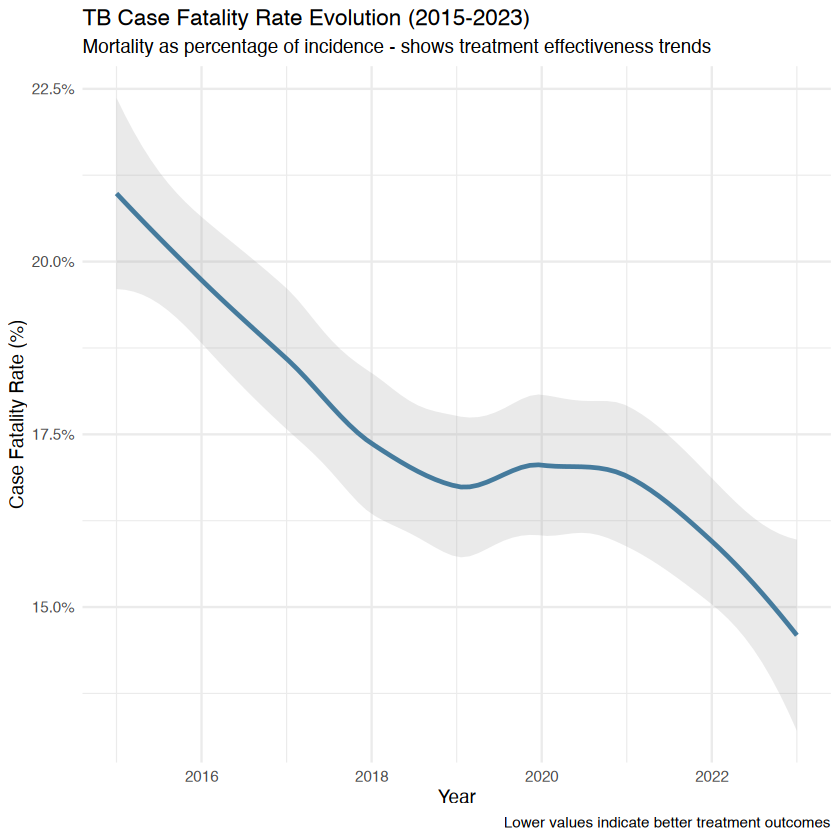

In [26]:
# Case fatality rate analysis
cfr_plot <- tb_dual_data %>%
  mutate(case_fatality_rate = (mean_mortality / mean_incidence) * 100) %>%
  
  ggplot(aes(x = year, y = mean_mortality)) +
  # geom_line(size = 1.2, color = "#E63946") +
  # geom_point(size = 3, color = "#E63946") +
  
  # Add smooth trend
  geom_smooth(method = "loess", se = TRUE, alpha = 0.2, color = "#457B9D") +
  
  scale_y_continuous(labels = percent_format(scale = 1)) +
  
  labs(
    title = "TB Case Fatality Rate Evolution (2015-2023)",
    subtitle = "Mortality as percentage of incidence - shows treatment effectiveness trends",
    x = "Year",
    y = "Case Fatality Rate (%)",
    caption = "Lower values indicate better treatment outcomes"
  ) +
  
  theme_minimal()

print(cfr_plot)

TB Incidence-Mortality Relationship Over Time (arrow plot)

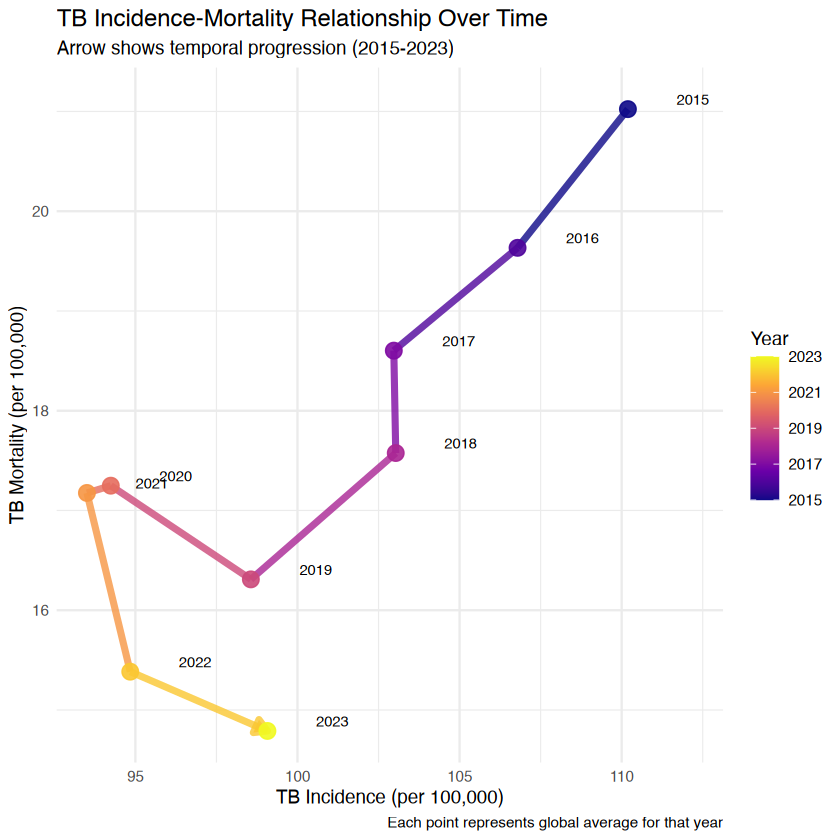

In [27]:
# Scatterplot showing incidence vs mortality with time trajectory
trajectory_plot <- tb_dual_data %>%
  ggplot(aes(x = mean_incidence, y = mean_mortality)) +
  
  # Path showing trajectory over time
  geom_path(aes(color = year), size = 1.5, alpha = 0.8, 
            arrow = arrow(length = unit(0.3, "cm"), type = "closed")) +
  
  # Points for each year
  geom_point(aes(color = year), size = 4, alpha = 0.9) +
  
  # Add year labels for key points
  geom_text(aes(label = year), nudge_x = 2, nudge_y = 0.1, size = 3) +
  
  scale_color_viridis_c(name = "Year", option = "plasma") +
  
  labs(
    title = "TB Incidence-Mortality Relationship Over Time",
    subtitle = "Arrow shows temporal progression (2015-2023)",
    x = "TB Incidence (per 100,000)",
    y = "TB Mortality (per 100,000)",
    caption = "Each point represents global average for that year"
  ) +
  
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    legend.position = "right"
  )

print(trajectory_plot)

TB Incidence-Mortality Relationship Over Time for Timor-Leste

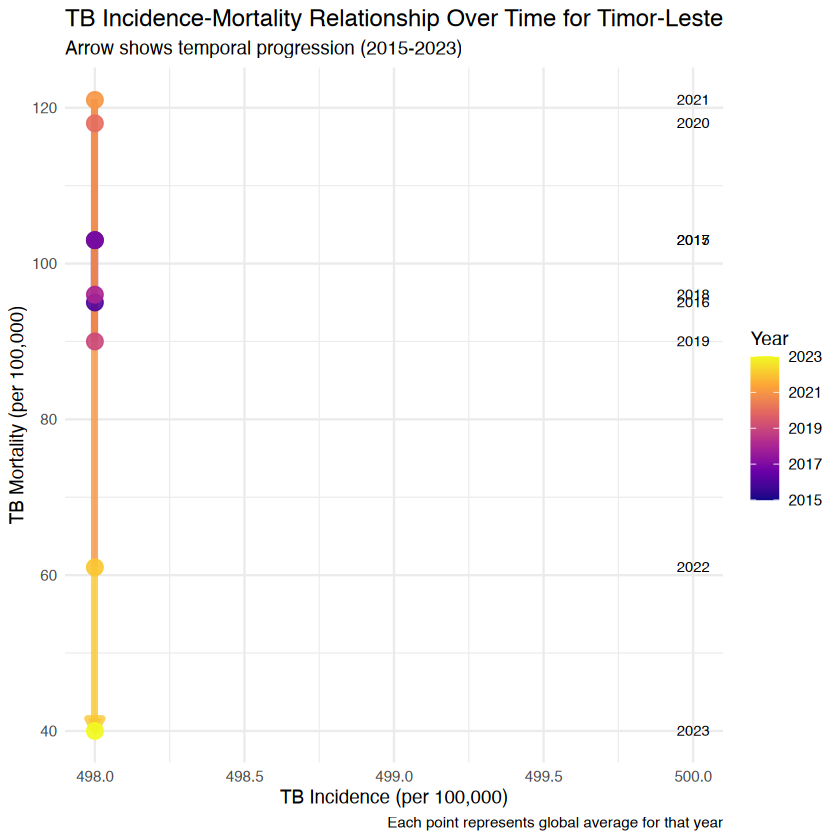

In [28]:
# Dual-axis time series plot
library(ggplot2)
library(scales)

# Prepare data for dual-axis plot
timor_leste_dual_data <- tb_data %>%
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(year)) %>%
  filter(country == "Timor-Leste") %>%
  group_by(year) %>%
  summarise(
    mean_incidence = mean(e_inc_100k, na.rm = TRUE),
    mean_mortality = mean(e_mort_100k, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(year = as.numeric(year))


# Scatterplot showing incidence vs mortality with time trajectory
trajectory_plot <- timor_leste_dual_data %>%
  ggplot(aes(x = mean_incidence, y = mean_mortality)) +
  
  # Path showing trajectory over time
  geom_path(aes(color = year), size = 1.5, alpha = 0.8, 
            arrow = arrow(length = unit(0.3, "cm"), type = "closed")) +
  
  # Points for each year
  geom_point(aes(color = year), size = 4, alpha = 0.9) +
  
  # Add year labels for key points
  geom_text(aes(label = year), nudge_x = 2, nudge_y = 0.1, size = 3) +
  
  scale_color_viridis_c(name = "Year", option = "plasma") +
  
  labs(
    title = "TB Incidence-Mortality Relationship Over Time for Timor-Leste",
    subtitle = "Arrow shows temporal progression (2015-2023)",
    x = "TB Incidence (per 100,000)",
    y = "TB Mortality (per 100,000)",
    caption = "Each point represents global average for that year"
  ) +
  
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    legend.position = "right"
  )

print(trajectory_plot)

TB Incidence vs Mortality: Regional Trajectories by WHO Region (2015-2023)


Faceted regional incidence vs mortality plot saved as: output/tb_incidence_vs_mortality_facet_regional.png


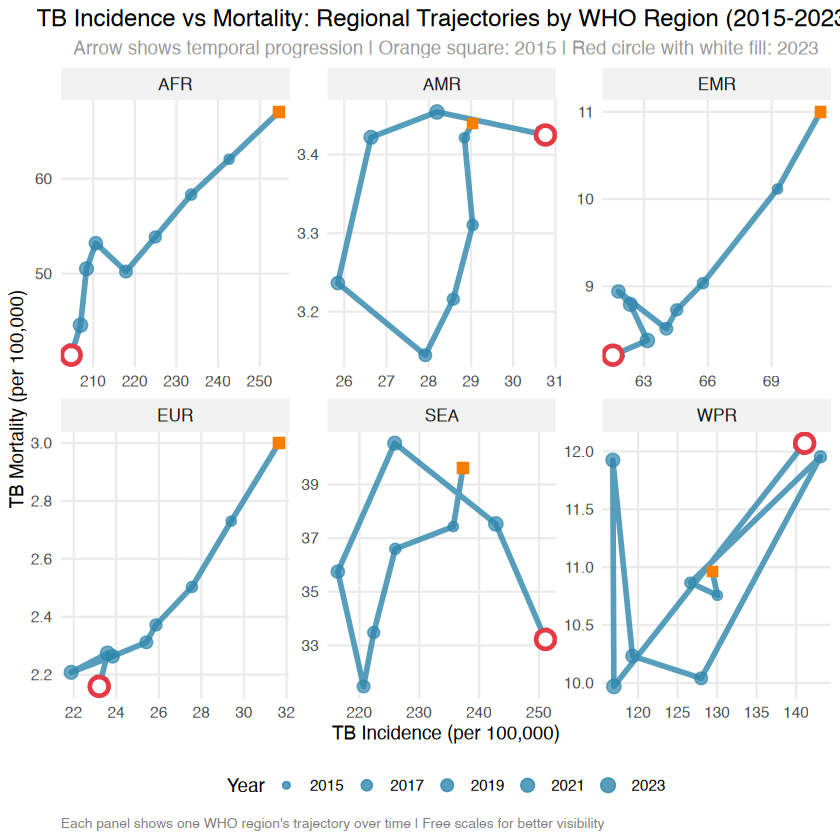

In [29]:
# Regional comparison of incidence vs mortality - FACETED VERSION
regional_comparison <- tb_data %>%
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(g_whoregion)) %>%
  group_by(g_whoregion, year) %>%
  summarise(
    mean_incidence = mean(e_inc_100k, na.rm = TRUE),
    mean_mortality = mean(e_mort_100k, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(year = as.numeric(year))

regional_facet_plot <- regional_comparison %>%
  ggplot(aes(x = mean_incidence, y = mean_mortality)) +
  
  # Trajectory paths for each region
  geom_path(color = "#2E86AB", size = 1.2, alpha = 0.8, 
            arrow = arrow(length = unit(0.2, "cm"), type = "closed")) +
  
  # Points for years (sized by year)
  geom_point(aes(size = year), color = "#2E86AB", alpha = 0.7) +
  
  # Latest year highlighted
  geom_point(data = . %>% filter(year == max(year)), 
             size = 4, alpha = 1, stroke = 1.5, shape = 21, 
             fill = "white", color = "#E63946") +
  
  # First year highlighted differently
  geom_point(data = . %>% filter(year == min(year)), 
             size = 3, alpha = 1, shape = 22, 
             fill = "#F77F00", color = "#F77F00") +
  
  # Facet by WHO region
  facet_wrap(~g_whoregion, scales = "free", ncol = 3) +
  
  scale_size_continuous(name = "Year", range = c(1.5, 3.5)) +
  
  labs(
    title = "TB Incidence vs Mortality: Regional Trajectories by WHO Region (2015-2023)",
    subtitle = "Arrow shows temporal progression | Orange square: 2015 | Red circle with white fill: 2023",
    x = "TB Incidence (per 100,000)",
    y = "TB Mortality (per 100,000)",
    caption = "Each panel shows one WHO region's trajectory over time | Free scales for better visibility"
  ) +
  
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 11, hjust = 0.5, color = "gray60"),
    strip.text = element_text(size = 10, face = "bold", 
                              margin = margin(b = 5, t = 5)),
    strip.background = element_rect(fill = "gray95", color = NA),
    axis.title = element_text(size = 11, face = "bold"),
    axis.text = element_text(size = 9),
    legend.position = "bottom",
    panel.grid.minor = element_blank(),
    plot.caption = element_text(size = 8, color = "gray50", hjust = 0)
  ) +
  guides(size = guide_legend(override.aes = list(color = "#2E86AB", alpha = 0.8)))

print(regional_facet_plot)

# Save the plot
ggsave("output/tb_incidence_vs_mortality_facet_regional.png", 
       plot = regional_facet_plot,
       width = 15, height = 11, dpi = 300, bg = "white")

cat("\nFaceted regional incidence vs mortality plot saved as: output/tb_incidence_vs_mortality_facet_regional.png\n")

Regional CFR data summary:
# A tibble: 6 x 4
  g_whoregion years_available avg_cfr countries
  <chr>       <chr>             <dbl>     <dbl>
1 AFR         2015-2023         21.6         47
2 AMR         2015-2023         17.7         43
3 EMR         2015-2023         12.7         22
4 EUR         2015-2023          9.34        52
5 SEA         2015-2023         13.5         10
6 WPR         2015-2023          9.3         34


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'



Regional CFR facet plot with Timor-Leste saved as: output/tb_cfr_by_region_facet_timor.png


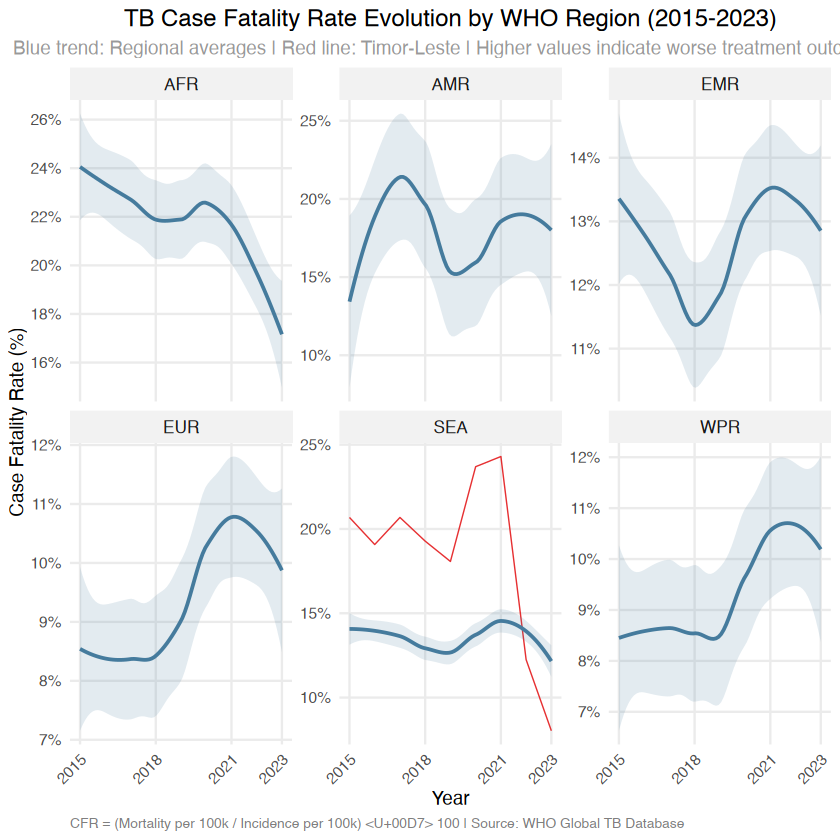

In [30]:
# Facet grid plot: Case Fatality Rate by WHO Region with Timor-Leste highlighted

# Prepare country-level CFR data for Timor-Leste
country_cfr_data <- tb_data %>%
  # Filter for complete cases
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(g_whoregion), !is.na(year)) %>%
  # Remove zero incidence to avoid division issues
  filter(e_inc_100k > 0) %>%
  mutate(year = as.numeric(year)) %>%
  
  # Calculate CFR for each country-year
  mutate(cfr_country = (e_mort_100k / e_inc_100k) * 100)

# Separate Timor-Leste data for highlighting
timor_cfr_data <- country_cfr_data %>%
  filter(country == "Timor-Leste")

# Prepare regional case fatality rate data
regional_cfr_data <- tb_data %>%
  # Filter for complete cases
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(g_whoregion), !is.na(year)) %>%
  # Remove zero incidence to avoid division issues
  filter(e_inc_100k > 0) %>%
  mutate(year = as.numeric(year)) %>%
  
  # Calculate CFR for each country-year
  mutate(cfr_country = (e_mort_100k / e_inc_100k) * 100) %>%
  
  # Calculate regional averages by year
  group_by(g_whoregion, year) %>%
  summarise(
    mean_cfr = mean(cfr_country, na.rm = TRUE),
    median_cfr = median(cfr_country, na.rm = TRUE),
    countries_count = n(),
    min_cfr = min(cfr_country, na.rm = TRUE),
    max_cfr = max(cfr_country, na.rm = TRUE),
    .groups = "drop"
  )

# Display summary statistics
cat("Regional CFR data summary:\n")
print(regional_cfr_data %>% 
      group_by(g_whoregion) %>% 
      summarise(
        years_available = paste(range(year), collapse = "-"),
        avg_cfr = round(mean(mean_cfr, na.rm = TRUE), 2),
        countries = round(mean(countries_count), 0),
        .groups = "drop"
      ))

# Create the facet grid plot with Timor-Leste
regional_cfr_plot <- regional_cfr_data %>%
  ggplot(aes(x = year, y = mean_cfr)) +
  
  # TIMOR-LESTE thin red line (added before smooth to appear behind)
  geom_line(data = timor_cfr_data,
            aes(y = cfr_country, group = country), 
            color = "#E31A1C", size = 0.3, alpha = 0.9) +
  
  # Add smooth trend line
  geom_smooth(method = "loess", se = TRUE, alpha = 0.15, 
              color = "#457B9D", fill = "#457B9D", size = 0.8) +
  
  # Separate panel for each region
  facet_wrap(~g_whoregion, scales = "free_y", ncol = 3) +
  
  # Scale formatting
  scale_x_continuous(
    breaks = c(2015, 2018, 2021, 2023),
    labels = c("2015", "2018", "2021", "2023")
  ) +
  scale_y_continuous(
    labels = function(x) paste0(round(x, 1), "%"),
    breaks = pretty_breaks(n = 5)
  ) +
  
  # Labels and theme
  labs(
    title = "TB Case Fatality Rate Evolution by WHO Region (2015-2023)",
    subtitle = "Blue trend: Regional averages | Red line: Timor-Leste | Higher values indicate worse treatment outcomes",
    x = "Year",
    y = "Case Fatality Rate (%)",
    caption = "CFR = (Mortality per 100k / Incidence per 100k) × 100 | Source: WHO Global TB Database"
  ) +
  
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 11, hjust = 0.5, color = "gray60"),
    strip.text = element_text(size = 10, face = "bold", 
                              margin = margin(b = 5, t = 5)),
    strip.background = element_rect(fill = "gray95", color = NA),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 9),
    axis.text.y = element_text(size = 9),
    axis.title = element_text(size = 11, face = "bold"),
    panel.grid.minor = element_blank(),
    plot.caption = element_text(size = 8, color = "gray50", hjust = 0)
  )

# Display the plot
print(regional_cfr_plot)

# Save the plot
ggsave("output/tb_cfr_by_region_facet_timor.png", 
       plot = regional_cfr_plot,
       width = 14, height = 10, dpi = 300, bg = "white")

cat("\nRegional CFR facet plot with Timor-Leste saved as: output/tb_cfr_by_region_facet_timor.png\n")

Regional mortality data summary:
# A tibble: 6 x 4
  g_whoregion years_available avg_mort countries
  <chr>       <chr>              <dbl>     <dbl>
1 AFR         2015-2023          53.5         47
2 AMR         2015-2023           3.51        43
3 EMR         2015-2023           9.08        22
4 EUR         2015-2023           2.5         52
5 SEA         2015-2023          36.2         10
6 WPR         2015-2023          11.5         34


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'



Regional facet plot with Timor-Leste saved as: output/tb_clean_by_region_facet_timor.png


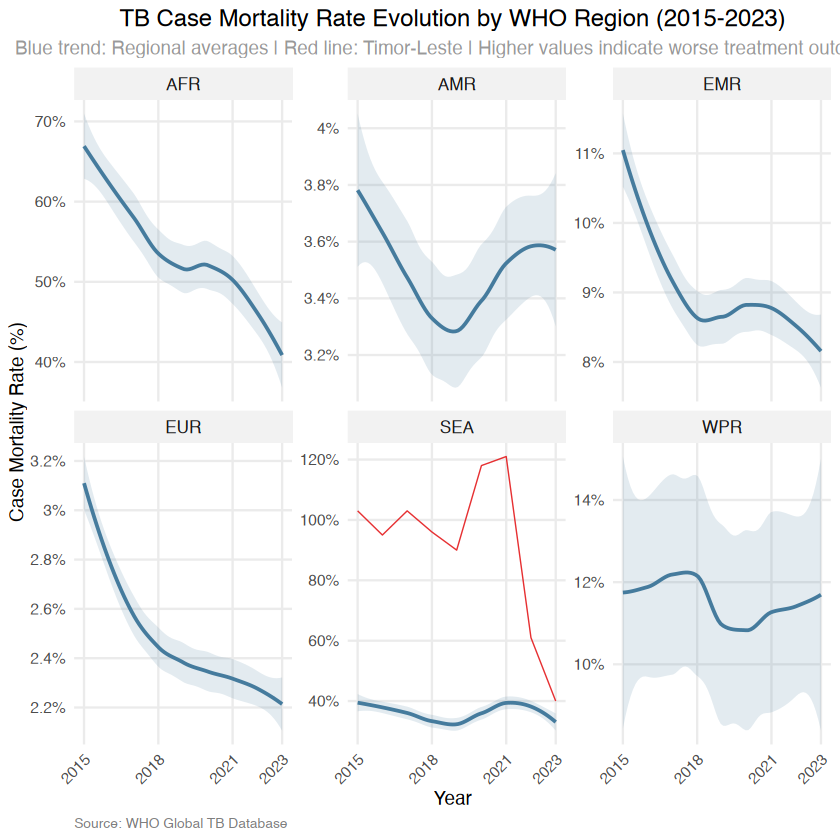

In [31]:
# Facet grid plot: Case Fatality Rate by WHO Region with Timor-Leste highlighted

# Prepare country-level CFR data for Timor-Leste
country_clean_data <- tb_data %>%
  # Filter for complete cases
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(g_whoregion), !is.na(year)) %>%
  # Remove zero incidence to avoid division issues
  filter(e_inc_100k > 0) %>%
  mutate(year = as.numeric(year))

# Separate Timor-Leste data for highlighting
timor_clean_data <- country_clean_data %>%
  filter(country == "Timor-Leste")

# Prepare regional case fatality rate data
regional_clean_data <- tb_data %>%
  # Filter for complete cases
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(g_whoregion), !is.na(year)) %>%
  # Remove zero incidence to avoid division issues
  filter(e_inc_100k > 0) %>%
  mutate(year = as.numeric(year)) %>%
  # Calculate regional averages by year
  group_by(g_whoregion, year) %>%
  summarise(
    mean_mort = mean(e_mort_100k, na.rm = TRUE),
    median_mort = median(e_mort_100k, na.rm = TRUE),
    countries_count = n(),
    min_cfr = min(e_mort_100k, na.rm = TRUE),
    max_cfr = max(e_mort_100k, na.rm = TRUE),
    .groups = "drop"
  )

# Display summary statistics
cat("Regional mortality data summary:\n")
print(regional_clean_data %>% 
      group_by(g_whoregion) %>% 
      summarise(
        years_available = paste(range(year), collapse = "-"),
        avg_mort = round(mean(mean_mort, na.rm = TRUE), 2),
        countries = round(mean(countries_count), 0),
        .groups = "drop"
      ))

# Create the facet grid plot with Timor-Leste
regional_clean_plot <- regional_clean_data %>%
  ggplot(aes(x = year, y = mean_mort)) +
  
  # TIMOR-LESTE thin red line (added before smooth to appear behind)
  geom_line(data = timor_clean_data,
            aes(y = e_mort_100k, group = country), 
            color = "#E31A1C", size = 0.3, alpha = 0.9) +
  
  # Add smooth trend line
  geom_smooth(method = "loess", se = TRUE, alpha = 0.15, 
              color = "#457B9D", fill = "#457B9D", size = 0.8) +
  
  # Separate panel for each region
  facet_wrap(~g_whoregion, scales = "free_y", ncol = 3) +
  
  # Scale formatting
  scale_x_continuous(
    breaks = c(2015, 2018, 2021, 2023),
    labels = c("2015", "2018", "2021", "2023")
  ) +
  scale_y_continuous(
    labels = function(x) paste0(round(x, 1), "%"),
    breaks = pretty_breaks(n = 5)
  ) +
  
  # Labels and theme
  labs(
    title = "TB Case Mortality Rate Evolution by WHO Region (2015-2023)",
    subtitle = "Blue trend: Regional averages | Red line: Timor-Leste | Higher values indicate worse treatment outcomes",
    x = "Year",
    y = "Case Mortality Rate (%)",
    caption = "Source: WHO Global TB Database"
  ) +
  
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 11, hjust = 0.5, color = "gray60"),
    strip.text = element_text(size = 10, face = "bold", 
                              margin = margin(b = 5, t = 5)),
    strip.background = element_rect(fill = "gray95", color = NA),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 9),
    axis.text.y = element_text(size = 9),
    axis.title = element_text(size = 11, face = "bold"),
    panel.grid.minor = element_blank(),
    plot.caption = element_text(size = 8, color = "gray50", hjust = 0)
  )

# Display the plot
print(regional_clean_plot)

# Save the plot
ggsave("output/tb_clean_by_region_facet_timor.png", 
       plot = regional_clean_plot,
       width = 14, height = 10, dpi = 300, bg = "white")

cat("\nRegional facet plot with Timor-Leste saved as: output/tb_clean_by_region_facet_timor.png\n")

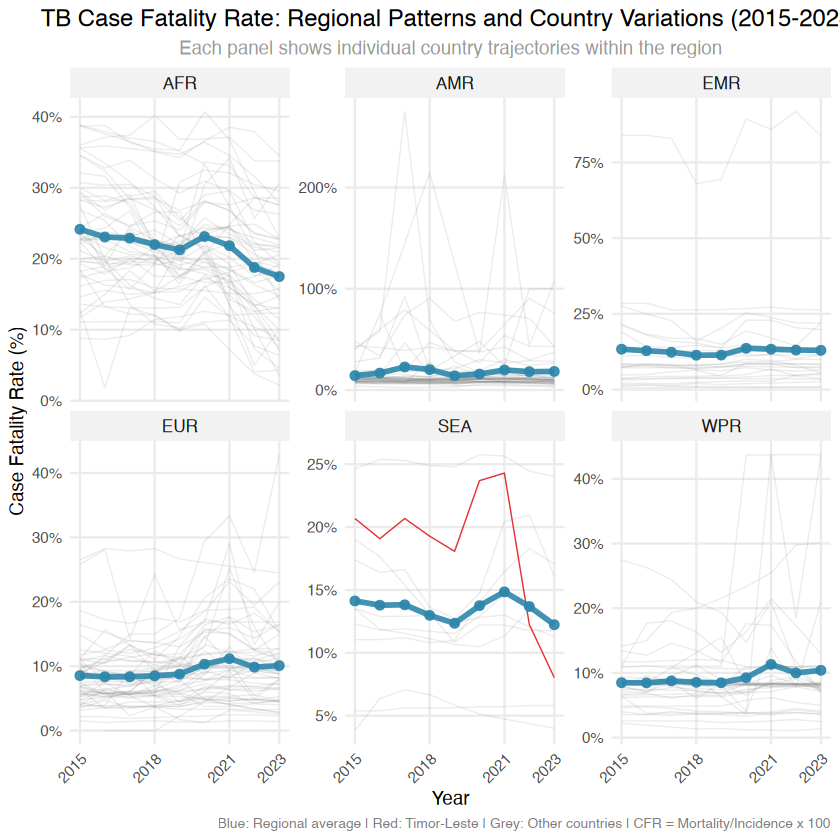

In [32]:
# Facet grid plot: Case Fatality Rate by WHO Region with individual countries

# Prepare country-level CFR data
country_cfr_data <- tb_data %>%
  # Filter for complete cases
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(g_whoregion), !is.na(year)) %>%
  # Remove zero incidence to avoid division issues
  filter(e_inc_100k > 0) %>%
  mutate(year = as.numeric(year)) %>%
  
  # Calculate CFR for each country-year
  mutate(cfr_country = (e_mort_100k / e_inc_100k) * 100)

# Alternative version with improved legend
regional_cfr_plot_clean <- country_cfr_data %>%
  # Add grouping variable for better legend control
  mutate(country_type = case_when(
    country == "Timor-Leste" ~ "Timor-Leste",
    TRUE ~ "Other Countries"
  )) %>%
  
  ggplot(aes(x = year, y = cfr_country)) +
  
  # Individual country trajectories (background)
  geom_line(data = . %>% filter(country_type == "Other Countries"),
            aes(group = country), 
            alpha = 0.15, color = "gray50", size = 0.3) +
  
  # Timor-Leste highlighted
  geom_line(data = . %>% filter(country_type == "Timor-Leste"),
            aes(group = country), 
            color = "#E31A1C", size = 0.3, alpha = 0.9) +
  
  # Regional average
  geom_line(data = regional_cfr_data,
            aes(y = mean_cfr, group = 1), 
            color = "#2E86AB", size = 1.2, alpha = 0.9) +
  geom_point(data = regional_cfr_data,
             aes(y = mean_cfr), 
             color = "#2E86AB", size = 2, alpha = 0.9) +
  
  facet_wrap(~g_whoregion, scales = "free_y", ncol = 3) +
  
  scale_x_continuous(breaks = c(2015, 2018, 2021, 2023)) +
  scale_y_continuous(labels = function(x) paste0(round(x, 1), "%")) +
  
  labs(
    title = "TB Case Fatality Rate: Regional Patterns and Country Variations (2015-2023)",
    subtitle = "Each panel shows individual country trajectories within the region",
    x = "Year",
    y = "Case Fatality Rate (%)",
    caption = "Blue: Regional average | Red: Timor-Leste | Grey: Other countries | CFR = Mortality/Incidence x 100"
  ) +
  
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 11, hjust = 0.5, color = "gray60"),
    strip.text = element_text(size = 10, face = "bold"),
    strip.background = element_rect(fill = "gray95", color = NA),
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid.minor = element_blank(),
    plot.caption = element_text(size = 8, color = "gray50")
  )

print(regional_cfr_plot_clean)

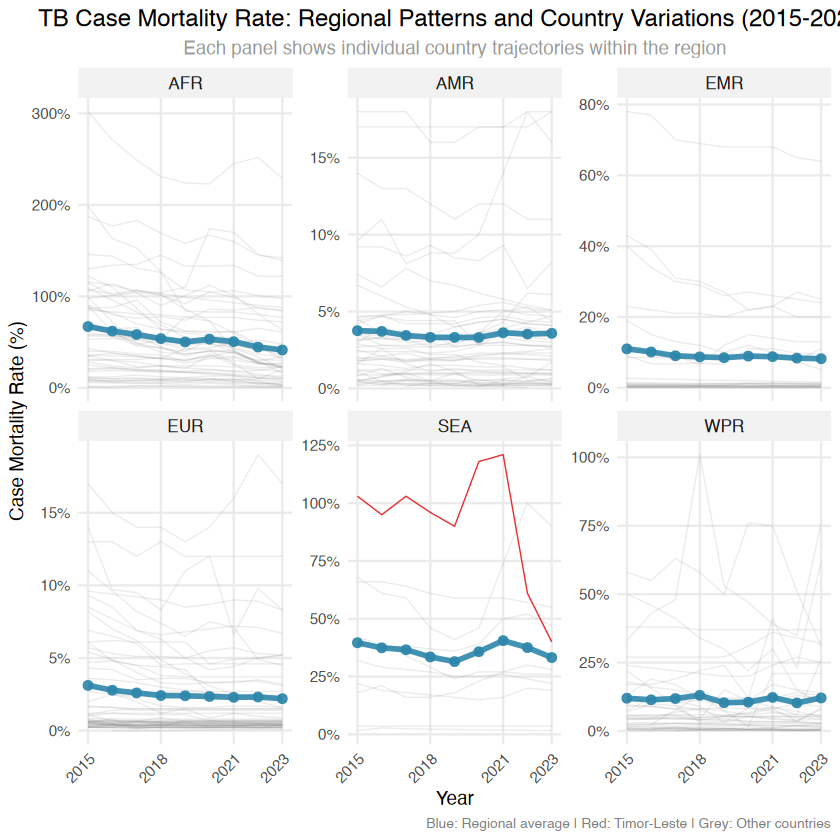

In [33]:

# Alternative version with improved legend
regional_mort_plot_clean <- country_clean_data %>%
  # Add grouping variable for better legend control
  mutate(country_type = case_when(
    country == "Timor-Leste" ~ "Timor-Leste",
    TRUE ~ "Other Countries"
  )) %>%
  
  ggplot(aes(x = year, y = e_mort_100k)) +
  
  # Individual country trajectories (background)
  geom_line(data = . %>% filter(country_type == "Other Countries"),
            aes(group = country), 
            alpha = 0.15, color = "gray50", size = 0.3) +
  
  # Timor-Leste highlighted
  geom_line(data = . %>% filter(country_type == "Timor-Leste"),
            aes(group = country), 
            color = "#E31A1C", size = 0.3, alpha = 0.9) +
  
  # Regional average
  geom_line(data = regional_clean_data,
            aes(y = mean_mort, group = 1), 
            color = "#2E86AB", size = 1.2, alpha = 0.9) +
  geom_point(data = regional_clean_data,
             aes(y = mean_mort), 
             color = "#2E86AB", size = 2, alpha = 0.9) +
  
  facet_wrap(~g_whoregion, scales = "free_y", ncol = 3) +
  
  scale_x_continuous(breaks = c(2015, 2018, 2021, 2023)) +
  scale_y_continuous(labels = function(x) paste0(round(x, 1), "%")) +
  
  labs(
    title = "TB Case Mortality Rate: Regional Patterns and Country Variations (2015-2023)",
    subtitle = "Each panel shows individual country trajectories within the region",
    x = "Year",
    y = "Case Mortality Rate (%)",
    caption = "Blue: Regional average | Red: Timor-Leste | Grey: Other countries"
  ) +
  
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 11, hjust = 0.5, color = "gray60"),
    strip.text = element_text(size = 10, face = "bold"),
    strip.background = element_rect(fill = "gray95", color = NA),
    axis.text.x = element_text(angle = 45, hjust = 1),
    panel.grid.minor = element_blank(),
    plot.caption = element_text(size = 8, color = "gray50")
  )

print(regional_mort_plot_clean)

### 2.2 Correlation analysis

Prepare and clean data for correlation

In [34]:
# --- 1. LOAD PACKAGES ---
# Load all necessary packages for cleaning and EDA
library(tidyverse)
library(janitor)
library(GGally)

# --- 2. ROBUST DATA LOADING AND CLEANING (CORRECTED) ---

file_path <- "output/tb_focused_2015_2023_with_descriptions.csv"

tb_clean <- tb_focused %>%
  # Filter for complete cases
  filter(!is.na(e_inc_100k), !is.na(e_mort_100k), !is.na(g_whoregion), !is.na(year)) %>%
  # Remove zero incidence to avoid division issues
  filter(e_inc_100k > 0) %>%
  mutate(year = as.numeric(year)) %>%
  mutate(
    # Now handle the factor conversions as before
    across(c(country, g_whoregion, iso3), as.factor),
    community_data_available = case_when(
      community_data_available == 1 ~ "Available",
      community_data_available == 0 ~ "Not Available",
      .default = NA
    ) %>% as.factor(),
    year = as.integer(year)
  )

# Let's re-inspect to be sure
cat("--- Structure of the Corrected Clean Data ---\n")
glimpse(tb_clean)
cat("\n")


Attaching package: 'janitor'


The following objects are masked from 'package:stats':

    chisq.test, fisher.test


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



--- Structure of the Corrected Clean Data ---
Rows: 1,875
Columns: 20
$ e_inc_100k               <dbl> 189, 189, 189, 189, 189, 183, 185, 184, 180, ~
$ e_mort_100k              <dbl> 40.00, 34.00, 30.00, 29.00, 26.00, 27.00, 26.~
$ e_inc_num                <dbl> 64000, 65000, 67000, 69000, 71000, 72000, 740~
$ c_cdr                    <dbl> 56, 64, 69, 70, 73, 64, 68, 69, 66, 87, 87, 8~
$ c_newinc                 <dbl> 35878, 41954, 46640, 48420, 52438, 45818, 503~
$ c_newinc_100k            <dbl> 106.0, 121.0, 131.0, 132.0, 139.0, 117.0, 126~
$ budget_tot               <dbl> NA, NA, NA, 10881354, 16957452, 19137128, 106~
$ exp_tot                  <dbl> NA, NA, 12071477, 12400144, 14984900, 1173232~
$ rcvd_tot_domestic        <dbl> NA, NA, NA, 551664, 284773, 0, 726302, NA, 24~
$ bmu                      <dbl> 708, 778, 817, 887, 873, 857, 852, 877, 872, ~
$ bmu_community_impl       <dbl> 539, 778, 817, 887, 719, 857, 718, 877, 872, ~
$ bmu_ref_data             <dbl> 539, 778, 817, 88

Create faceted correlation plot by WHO region

Adding missing grouping variables: `g_whoregion`


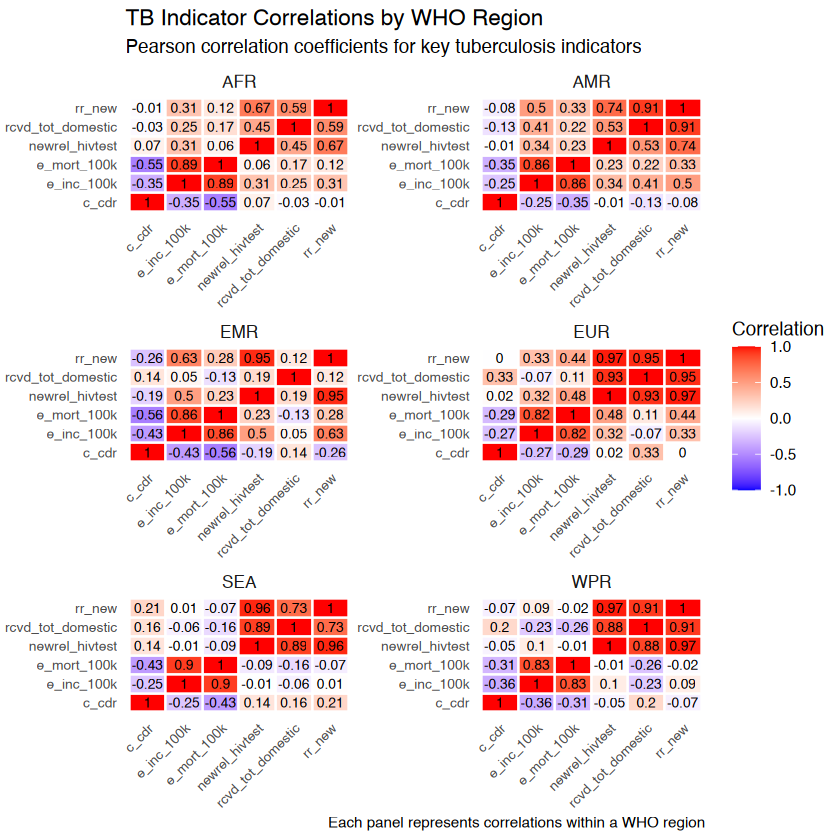

In [35]:
# Create faceted correlation plot by WHO region
correlation_by_region <- tb_clean %>%
  # Select numeric variables and region
  select(
    g_whoregion,
    e_mort_100k, c_cdr, e_inc_100k,
    rcvd_tot_domestic, newrel_hivtest, rr_new
  ) %>%
  # Remove rows with missing region data
  filter(!is.na(g_whoregion)) %>%
  # Group by region and calculate correlations
  group_by(g_whoregion) %>%
  # Nest data for each region
  nest() %>%
  # Calculate correlation matrix for each region
  mutate(
    cor_matrix = map(data, ~ {
      .x %>%
        select(where(is.numeric)) %>%
        cor(use = "pairwise.complete.obs", method = "pearson")
    })
  ) %>%
  # Convert correlation matrices to long format
  mutate(
    cor_long = map2(cor_matrix, g_whoregion, ~ {
      .x %>%
        as.data.frame() %>%
        rownames_to_column("var1") %>%
        pivot_longer(cols = -var1, names_to = "var2", values_to = "correlation") %>%
        mutate(region = .y)
    })
  ) %>%
  # Combine all regions
  select(cor_long) %>%
  unnest(cor_long) %>%
  ungroup()

# Create the faceted correlation plot
faceted_correlation_plot <- correlation_by_region %>%
  # Create the plot
  ggplot(aes(x = var1, y = var2, fill = correlation)) +
  geom_tile(color = "white", size = 0.5) +
  geom_text(
    aes(label = round(correlation, 2)),
    color = "black",
    size = 2.8
  ) +
  scale_fill_gradient2(
    low = "blue",
    mid = "white",
    high = "red",
    midpoint = 0,
    limit = c(-1, 1),
    name = "Correlation"
  ) +
  facet_wrap(~ region, scales = "free", ncol = 2) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),
    axis.text.y = element_text(size = 8),
    strip.text = element_text(size = 10, face = "bold"),
    panel.grid = element_blank(),
    axis.title = element_blank()
  ) +
  labs(
    title = "TB Indicator Correlations by WHO Region",
    subtitle = "Pearson correlation coefficients for key tuberculosis indicators",
    caption = "Each panel represents correlations within a WHO region"
  )

print(faceted_correlation_plot)

Simplified faceted correlation plot by WHO region

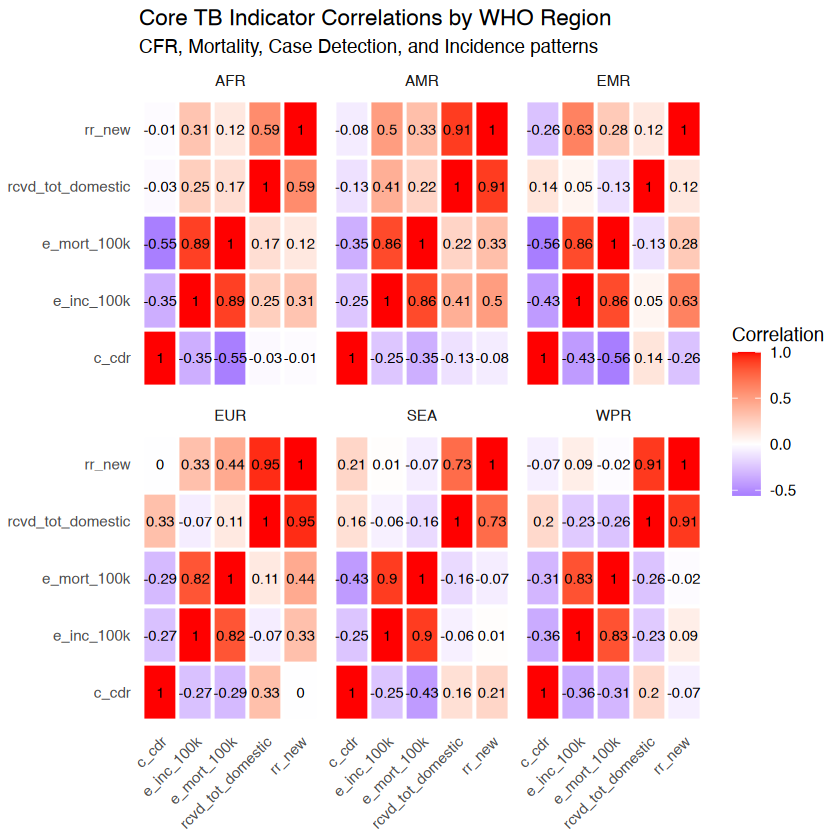

In [36]:
# Simplified faceted correlation plot
simplified_correlation_plot <- tb_clean %>%
  select(
    g_whoregion,
    e_mort_100k, c_cdr, e_inc_100k, rcvd_tot_domestic, rr_new
  ) %>%
  filter(!is.na(g_whoregion)) %>%
  group_by(g_whoregion) %>%
  nest() %>%
  mutate(
    cor_matrix = map(data, ~ {
      .x %>%
        select(where(is.numeric)) %>%
        cor(use = "pairwise.complete.obs")
    }),
    cor_long = map2(cor_matrix, g_whoregion, ~ {
      .x %>%
        as.data.frame() %>%
        rownames_to_column("var1") %>%
        pivot_longer(cols = -var1, names_to = "var2", values_to = "correlation") %>%
        mutate(region = .y)
    })
  ) %>%
  unnest(cor_long) %>%
  ungroup() %>%
  ggplot(aes(x = var1, y = var2, fill = correlation)) +
  geom_tile(color = "white", size = 0.8) +
  geom_text(aes(label = round(correlation, 2)), size = 3) +
  scale_fill_gradient2(
    low = "blue", mid = "white", high = "red",
    midpoint = 0, name = "Correlation"
  ) +
  facet_wrap(~ region, ncol = 3) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.title = element_blank(),
    panel.grid = element_blank()
  ) +
  labs(
    title = "Core TB Indicator Correlations by WHO Region",
    subtitle = "CFR, Mortality, Case Detection, and Incidence patterns"
  )

print(simplified_correlation_plot)

Correlation plot for Timor-Leste

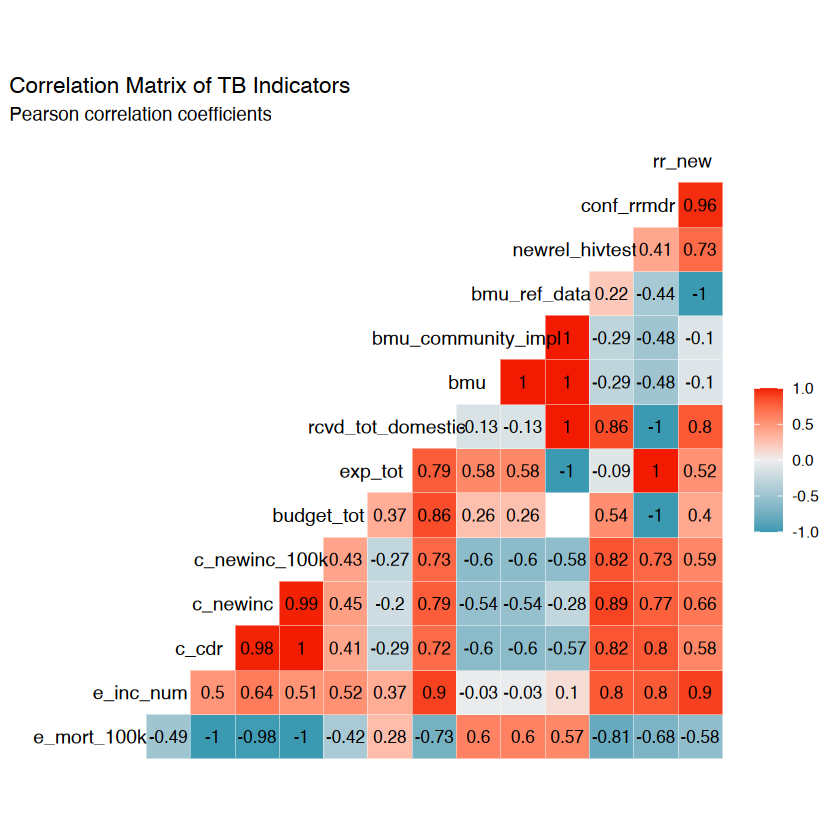

In [37]:
tb_clean_tl <- tb_clean %>%
  filter(country == "Timor-Leste") %>%
  select(-c(e_inc_100k)) %>%
  # select(
  #   cfr_country, e_mort_100k, c_cdr, c_newinc_100k,
  #   budget_tot, exp_tot, newrel_hivtest, rr_new
  # ) %>%
  select(where(is.numeric), -year)


correlation_plot <- tb_clean_tl %>%
  ggcorr(
    method = c("pairwise", "pearson"),
    label = TRUE,
    label_size = 3.5,
    label_round = 2,
    hjust = 0.8,
    size = 4,
    layout.exp = 2
  ) +
  labs(
    title = "Correlation Matrix of TB Indicators",
    subtitle = "Pearson correlation coefficients"
  )
print(correlation_plot)

Multi-level correlation analysis

In [38]:
# Multi-level correlation analysis
correlation_analyses <- list(
  global = tb_clean %>% 
    select(where(is.numeric), -year) %>%
    cor(use = "pairwise.complete.obs"),
    
  by_region = tb_clean %>%
    group_by(g_whoregion) %>%
    group_map(~ cor(select(.x, where(is.numeric), -year), 
                    use = "pairwise.complete.obs")),
                    
  timor_leste_focus = tb_clean %>%
    filter(country == "Timor-Leste") %>%
    select(where(is.numeric), -year) %>%
    cor(use = "pairwise.complete.obs")
)

Warning message in cor(., use = "pairwise.complete.obs"):
"the standard deviation is zero"


Export correlation data in long format

In [39]:
# Export correlation matrix in long (tidy) format
timor_leste_correlations_long <- correlation_analyses$timor_leste_focus %>%
  as.data.frame() %>%
  rownames_to_column(var = "variable1") %>%
  pivot_longer(
    cols = -variable1,
    names_to = "variable2", 
    values_to = "correlation"
  ) %>%
  # Remove duplicate pairs (since correlation matrix is symmetric)
  filter(variable1 <= variable2) %>%
  # Round correlations for readability
  mutate(correlation = round(correlation, 4))

# Export long format
timor_leste_correlations_long %>%
  write_csv("output/timor_leste_correlations_long.csv")

cat("Long format correlation data exported\n")

Long format correlation data exported


Simple one-line export

In [40]:
# Simple one-line export
write_csv(correlation_analyses$timor_leste_focus %>% as.data.frame() %>% rownames_to_column("variable"), 
          "output/timor_leste_correlations_simple.csv")

## Phase 3. Multivariate analysis

### 3.1  Fixed Effects panel regression model

#### The Goal
Our objective is to answer: **"What factors influence the evolution of the TB incidence rate (`e_inc_100k`)?"** We will use a **two-way fixed effects model**, which is the best practice for your data. This model will control for:
1.  **Country Fixed Effects:** All stable, unobserved characteristics of each country (e.g., geography, culture, political system).
2.  **Year Fixed Effects:** Global shocks that affect all countries in a specific year (most importantly, the COVID-19 pandemic).

#### Step 1: Setup - Load Required Libraries

In [41]:
# Load the libraries
library(tidyverse)
library(plm)
library(broom)
library(broom.helpers)
library(modelsummary)
library(gtsummary)


Attaching package: 'plm'


The following objects are masked from 'package:dplyr':

    between, lag, lead



Attaching package: 'gtsummary'


The following objects are masked from 'package:broom.helpers':

    all_categorical, all_continuous, all_contrasts, all_dichotomous,
    all_interaction, all_intercepts




#### Step 2: Data Preparation

In [42]:
# Let's assume your 'tb_clean' tibble is already loaded.
# First, inspect the data to ensure variable names are correct.
glimpse(tb_clean)

Rows: 1,875
Columns: 20
$ e_inc_100k               <dbl> 189, 189, 189, 189, 189, 183, 185, 184, 180, ~
$ e_mort_100k              <dbl> 40.00, 34.00, 30.00, 29.00, 26.00, 27.00, 26.~
$ e_inc_num                <dbl> 64000, 65000, 67000, 69000, 71000, 72000, 740~
$ c_cdr                    <dbl> 56, 64, 69, 70, 73, 64, 68, 69, 66, 87, 87, 8~
$ c_newinc                 <dbl> 35878, 41954, 46640, 48420, 52438, 45818, 503~
$ c_newinc_100k            <dbl> 106.0, 121.0, 131.0, 132.0, 139.0, 117.0, 126~
$ budget_tot               <dbl> NA, NA, NA, 10881354, 16957452, 19137128, 106~
$ exp_tot                  <dbl> NA, NA, 12071477, 12400144, 14984900, 1173232~
$ rcvd_tot_domestic        <dbl> NA, NA, NA, 551664, 284773, 0, 726302, NA, 24~
$ bmu                      <dbl> 708, 778, 817, 887, 873, 857, 852, 877, 872, ~
$ bmu_community_impl       <dbl> 539, 778, 817, 887, 719, 857, 718, 877, 872, ~
$ bmu_ref_data             <dbl> 539, 778, 817, 887, 719, 857, 718, 877, 872, ~
$ community_data

In [43]:
# 1. Select the variables for the model
# We'll choose our target variable (e_inc_100k) and a few key predictors.
# It's good practice to use the ISO code for the country identifier as it's unique.
model_data <- tb_clean %>%
  select(
    # Identifier variables
    iso3, 
    country, 
    year,
    
    # Target variable (Y)
    e_mort_100k,
    
    # Predictor variables (X)
    c_cdr,             # Case detection rate
    rcvd_tot_domestic, # Domestic funding
    rr_new,            # Drug resistance indicator
    bmu_community_impl # Number of Basic Management Units with data on referrals
  )

# 2. Handle missing values (NA)
# Fixed effects models cannot handle missing data. We'll remove rows with any NAs.
# In a full research project, you might consider imputation, but this is the standard first step.
model_data_clean <- model_data %>%
  drop_na()

# 3. Create a panel data frame (pdata.frame)
# This is a special type of data frame that plm needs. We tell it which
# column identifies the individual (country) and which identifies the time (year).
p_data <- pdata.frame(model_data_clean, index = c("iso3", "year"))

# You can inspect the new panel data frame
# It will look similar, but it now has special properties for panel models.
head(p_data)

,iso3,country,year,e_mort_100k,c_cdr,rcvd_tot_domestic,rr_new,bmu_community_impl
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG-2018,AFG,Afghanistan,2018,29,70,551664,253,887
AFG-2019,AFG,Afghanistan,2019,26,73,284773,263,719
AFG-2020,AFG,Afghanistan,2020,27,64,0,280,857
AFG-2021,AFG,Afghanistan,2021,26,68,726302,390,718
AFG-2023,AFG,Afghanistan,2023,24,66,240954,442,872
AGO-2017,AGO,Angola,2017,96,50,27985663,176,0


#### Step 3: Build and Run the Model

In [44]:
# 1. Define the model formula
# The format is target_variable ~ predictor1 + predictor2 + ...
fe_formula <- e_mort_100k ~ c_cdr + rcvd_tot_domestic + rr_new + bmu_community_impl

# 2. Run the two-way fixed effects model
# model = "within" specifies a fixed effects model.
# effect = "twoways" specifies we want both country ("individual") and year ("time") fixed effects.
fe_model <- plm(
  formula = fe_formula,
  data = p_data,
  model = "within",
  effect = "twoways" 
)

#### Step 4: Interpret the Results

Method A: The Standard Summary

In [45]:
summary(fe_model)

Twoways effects Within Model

Call:
plm(formula = fe_formula, data = p_data, effect = "twoways", 
    model = "within")

Unbalanced Panel: n = 107, T = 1-7, N = 489

Residuals:
       Min.     1st Qu.      Median     3rd Qu.        Max. 
-39.2748546  -3.0638107  -0.0036412   2.4555776  49.7005570 

Coefficients:
                      Estimate  Std. Error  t-value  Pr(>|t|)    
c_cdr              -5.7005e-01  5.0194e-02 -11.3569 < 2.2e-16 ***
rcvd_tot_domestic   1.3582e-07  4.2021e-08   3.2323 0.0013377 ** 
rr_new              1.3139e-03  3.6597e-04   3.5901 0.0003748 ***
bmu_community_impl -1.4772e-03  2.3137e-03  -0.6385 0.5235736    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Total Sum of Squares:    32918
Residual Sum of Squares: 24143
R-Squared:      0.26655
Adj. R-Squared: 0.037837
F-statistic: 33.7977 on 4 and 372 DF, p-value: < 2.22e-16

In [46]:
fe_model %>% tbl_regression()

<div id="hpuveizegv" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#hpuveizegv table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#hpuveizegv thead, #hpuveizegv tbody, #hpuveizegv tfoot, #hpuveizegv tr, #hpuveizegv td, #hpuveizegv th {
  border-style: none;
}

#hpuveizegv p {
  margin: 0;
  padding: 0;
}

#hpuveizegv .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

Method B: Tidy Output with `broom`

In [47]:
# Get a tidy tibble of the model coefficients
tidy(fe_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
c_cdr,-5.700469e-01,5.019374e-02,-11.356933,7.280235e-26
rcvd_tot_domestic,1.358223e-07,4.202055e-08,3.232282,1.337664e-03
rr_new,1.313890e-03,3.659734e-04,3.590123,3.748121e-04
bmu_community_impl,-1.477176e-03,2.313690e-03,-0.638450,5.235736e-01


Method C: Professional Regression Table with `modelsummary` 

In [48]:
# Create a beautiful summary table
# The 'stars = TRUE' argument adds the significance stars.
modelsummary(fe_model, stars = TRUE)


+--------------------+-----------+
|                    | (1)       |
+====================+===========+
| c_cdr              | -0.570*** |
+--------------------+-----------+
|                    | (0.050)   |
+--------------------+-----------+
| rcvd_tot_domestic  | 0.000**   |
+--------------------+-----------+
|                    | (0.000)   |
+--------------------+-----------+
| rr_new             | 0.001***  |
+--------------------+-----------+
|                    | (0.000)   |
+--------------------+-----------+
| bmu_community_impl | -0.001    |
+--------------------+-----------+
|                    | (0.002)   |
+--------------------+-----------+
| Num.Obs.           | 489       |
+--------------------+-----------+
| R2                 | 0.267     |
+--------------------+-----------+
| R2 Adj.            | 0.038     |
+--------------------+-----------+
| AIC                | 3304.5    |
+--------------------+-----------+
| BIC                | 3325.5    |
+------------------

Simple regression model for Timor-Leste to compare with global trends

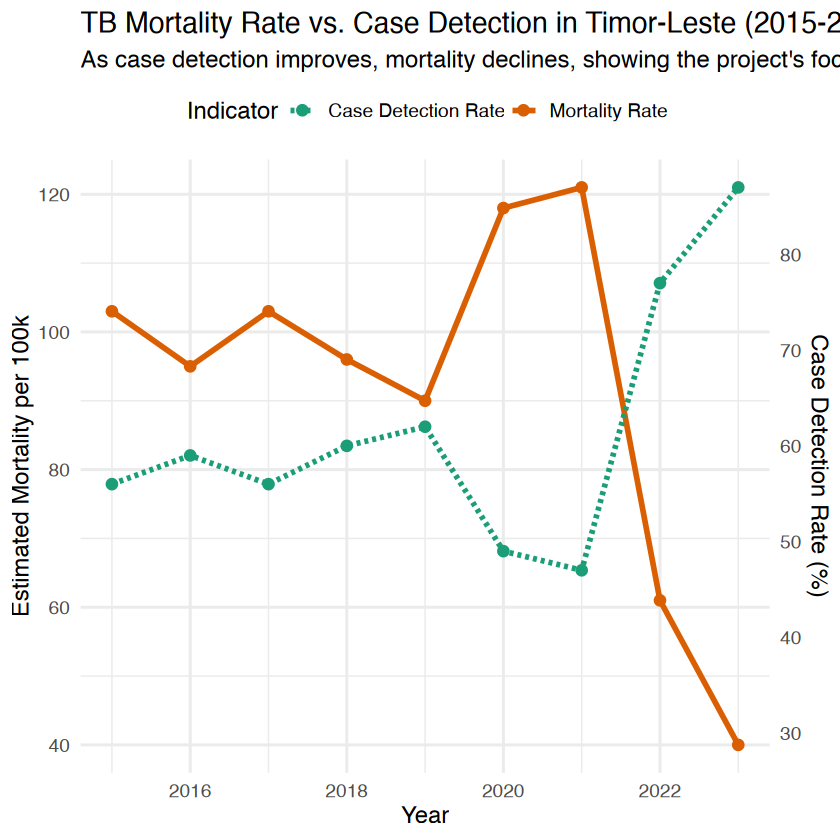

In [49]:
# 1. Filter your clean data for Timor-Leste only
# Using 'iso3' is safest, assuming Timor-Leste's code is 'TLS'. 
# If not, use country == "Timor-Leste".
timor_data <- tb_clean %>%
  filter(iso3 == "TLS")

# --- Step 2: Visualizing the Timor-Leste Story ---

# Use the 'timor_data' we created in the previous step

# A powerful visual is a dual-axis chart showing how incidence and case detection move over time.

# 1. Calculate a scaling factor to make the two axes comparable
# This finds the ratio between the max values of the two variables to scale the second axis
scale_factor <- max(timor_data$e_mort_100k, na.rm = TRUE) / max(timor_data$c_cdr, na.rm = TRUE)

# 2. Create the plot using ggplot2
ggplot(timor_data, aes(x = year)) +
  # Plot Incidence Rate (e_inc_100k) on the primary Y-axis
  geom_line(aes(y = e_mort_100k, color = "Mortality Rate"), size = 1.2) +
  geom_point(aes(y = e_mort_100k, color = "Mortality Rate"), size = 2.5) +
  
  # Plot Case Detection Rate (c_cdr) on the secondary Y-axis
  # We apply the scaling factor here
  geom_line(aes(y = c_cdr * scale_factor, color = "Case Detection Rate"), size = 1.2, linetype = "dashed") +
  geom_point(aes(y = c_cdr * scale_factor, color = "Case Detection Rate"), size = 2.5) +
  
  # Define the secondary Y-axis by "un-scaling" the values
  scale_y_continuous(
    name = "Estimated Mortality per 100k",
    sec.axis = sec_axis(~./scale_factor, name = "Case Detection Rate (%)")
  ) +
  
  # Add titles and clean up the theme
  labs(
    title = "TB Mortality Rate vs. Case Detection in Timor-Leste (2015-2023)",
    subtitle = "As case detection improves, mortality declines, showing the project's focus is relevant",
    x = "Year",
    y = "Estimated Mortality per 100k",
    color = "Indicator"
  ) +
  scale_color_manual(values = c("Mortality Rate" = "#d95f02", "Case Detection Rate" = "#1b9e77")) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top")

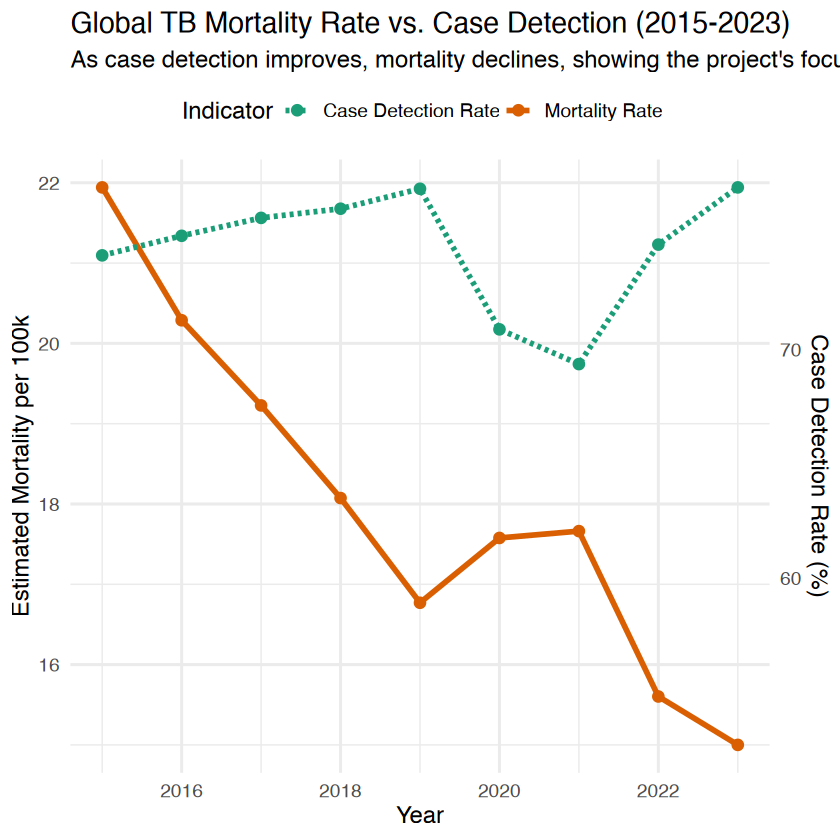

In [50]:

tb_dual_data <- tb_clean %>%
  group_by(year) %>%
  summarise(
    mean_cdr = mean(c_cdr, na.rm = TRUE),
    mean_mortality = mean(e_mort_100k, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  mutate(year = as.numeric(year))

# --- Step 2: Visualizing the Timor-Leste Story ---

# Use the 'timor_data' we created in the previous step

# A powerful visual is a dual-axis chart showing how incidence and case detection move over time.

# 1. Calculate a scaling factor to make the two axes comparable
# This finds the ratio between the max values of the two variables to scale the second axis
scale_factor <- max(tb_dual_data$mean_mortality, na.rm = TRUE) / max(tb_dual_data$mean_cdr, na.rm = TRUE)

# 2. Create the plot using ggplot2
ggplot(tb_dual_data, aes(x = year)) +
  # Plot Incidence Rate (e_inc_100k) on the primary Y-axis
  geom_line(aes(y = mean_mortality, color = "Mortality Rate"), size = 1.2) +
  geom_point(aes(y = mean_mortality, color = "Mortality Rate"), size = 2.5) +
  
  # Plot Case Detection Rate (c_cdr) on the secondary Y-axis
  # We apply the scaling factor here
  geom_line(aes(y = mean_cdr * scale_factor, color = "Case Detection Rate"), size = 1.2, linetype = "dashed") +
  geom_point(aes(y = mean_cdr * scale_factor, color = "Case Detection Rate"), size = 2.5) +
  
  # Define the secondary Y-axis by "un-scaling" the values
  scale_y_continuous(
    name = "Estimated Mortality per 100k",
    sec.axis = sec_axis(~./scale_factor, name = "Case Detection Rate (%)")
  ) +
  
  # Add titles and clean up the theme
  labs(
    title = "Global TB Mortality Rate vs. Case Detection (2015-2023)",
    subtitle = "As case detection improves, mortality declines, showing the project's focus is relevant",
    x = "Year",
    y = "Estimated Mortality per 100k",
    color = "Indicator"
  ) +
  scale_color_manual(values = c("Mortality Rate" = "#d95f02", "Case Detection Rate" = "#1b9e77")) +
  theme_minimal(base_size = 14) +
  theme(legend.position = "top")

# A tibble: 3 x 4
   year actual predicted residual 
  <dbl>  <dbl>     <dbl> <pseries>
1  2017    103      109. -5.891980
2  2018     96      104. -7.678486
3  2020    118      104. 13.570466


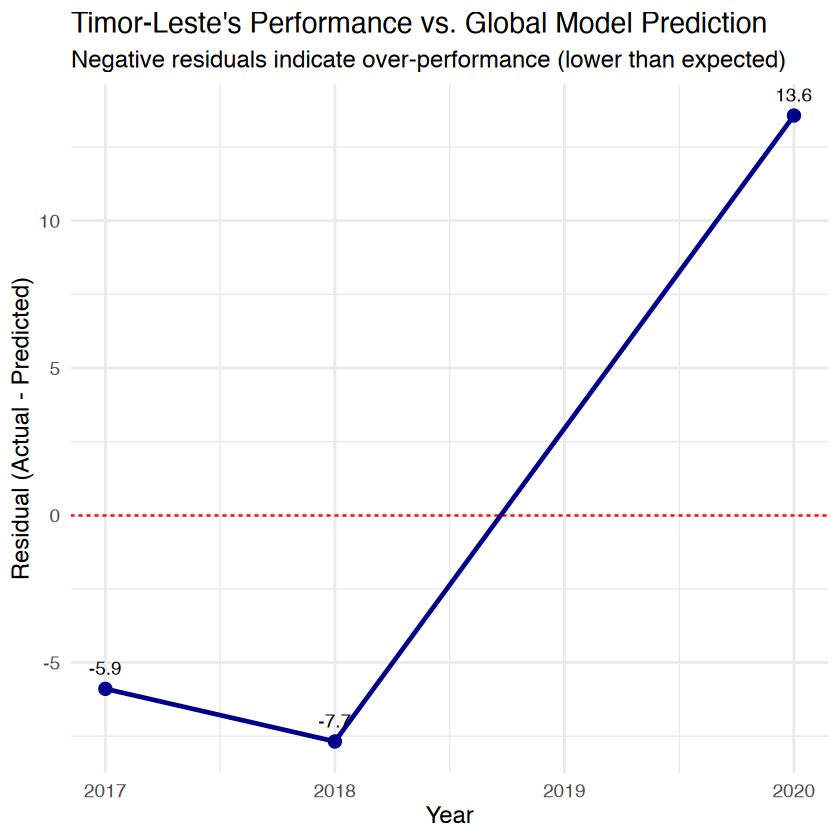

In [51]:
# --- Diagnostic Step: Analyze Timor-Leste's Performance vs. Prediction ---

# 1. Use broom::augment() to get fitted values and residuals
# This is the safest way to get predictions and residuals attached to your original data.
# It automatically handles the data alignment for you.
augmented_data <- augment(fe_model, data = p_data)

# 2. Filter for Timor-Leste
timor_augmented <- augmented_data %>%
  # Use .rownames to get back your original identifiers
  mutate(iso3 = sub("-.*", "", .rownames),
         year = as.numeric(sub(".*-", "", .rownames))) %>%
  filter(iso3 == "TLS") %>%
  # Rename columns for clarity
  rename(
    actual = e_mort_100k,
    predicted = .fitted,
    residual = .resid
  )


# Let's look at the result
# You'll have a table showing actual vs. predicted for each year.
print(timor_augmented %>% select(year, actual, predicted, residual))


# 3. Visualize the Residuals over Time
ggplot(timor_augmented, aes(x = year, y = residual)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  geom_line(color = "darkblue", size = 1) +
  geom_point(color = "darkblue", size = 3) +
  geom_text(aes(label = round(residual, 1)), vjust = -1, color = "black") + # Optional: add labels
  labs(
    title = "Timor-Leste's Performance vs. Global Model Prediction",
    subtitle = "Negative residuals indicate over-performance (lower than expected)",
    x = "Year",
    y = "Residual (Actual - Predicted)"
  ) +
  theme_minimal(base_size = 14)

### 3.2 Regression trees model

#### Step 1: Setup - Load Required Libraries

In [52]:
library(rpart)
library(rpart.plot)

#### Step 2: Data Preparation

In [53]:
# Define the formula we'll use for all trees. This ensures consistency.
# We're predicting the Case Fatality Rate (cfr).
tree_formula <- e_mort_100k ~ c_cdr + rcvd_tot_domestic + rr_new + bmu_community_impl

# --- Prepare data for 2018 ---
data_2018 <- tb_clean %>%
  filter(year == 2018) %>%
  select(e_mort_100k, c_cdr, rcvd_tot_domestic, rr_new, bmu_community_impl) %>%
  drop_na()

# --- Prepare data for 2019 (the pre-pandemic baseline) ---
data_2019 <- tb_clean %>%
  filter(year == 2019) %>%
  select(e_mort_100k, c_cdr, rcvd_tot_domestic, rr_new, bmu_community_impl) %>%
  drop_na()

# --- Prepare data for 2019 (the pre-pandemic baseline) ---
data_2020 <- tb_clean %>%
  filter(year == 2020) %>%
  select(e_mort_100k, c_cdr, rcvd_tot_domestic, rr_new, bmu_community_impl) %>%
  drop_na()

# --- Prepare data for 2019 (the pre-pandemic baseline) ---
data_2021 <- tb_clean %>%
  filter(year == 2021) %>%
  select(e_mort_100k, c_cdr, rcvd_tot_domestic, rr_new, bmu_community_impl) %>%
  drop_na()

# --- Prepare data for 2022 ---
data_2022 <- tb_clean %>%
  filter(year == 2022) %>%
  select(e_mort_100k, c_cdr, rcvd_tot_domestic, rr_new, bmu_community_impl) %>%
  drop_na()

# --- Prepare data for 2023 (the most recent state) ---
data_2023 <- tb_clean %>%
  filter(year == 2023) %>%
  select(e_mort_100k, c_cdr, rcvd_tot_domestic, rr_new, bmu_community_impl) %>%
  drop_na()

#### Step 3: Build and Run the Models for various years

Year 2018

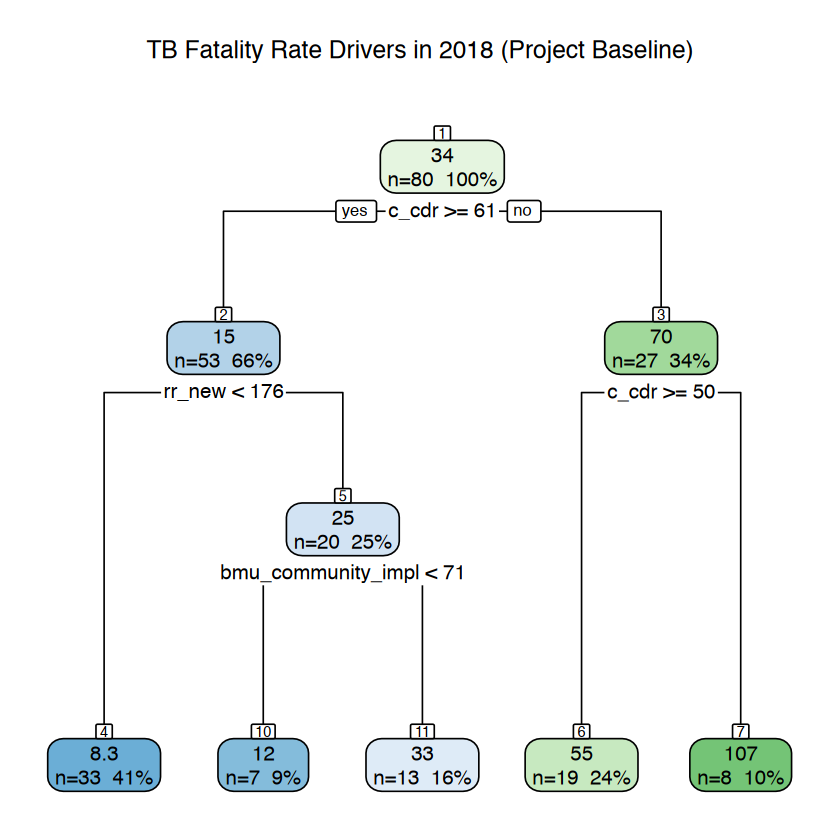

In [54]:
# Build the tree model for 2018
tree_2018 <- rpart(
  tree_formula, 
  data = data_2018,
  control = rpart.control(cp = 0.01) # Prunes the tree to keep it simple
)

# Create the beautiful flowchart plot
rpart.plot(
  tree_2018,
  type = 2, 
  extra = 101, # Shows the average value and percentage of observations
  box.palette = "BuGn", # Use a nice color palette
  nn = TRUE, # Show node numbers
  main = "TB Fatality Rate Drivers in 2018 (Project Baseline)"
)

Year 2019

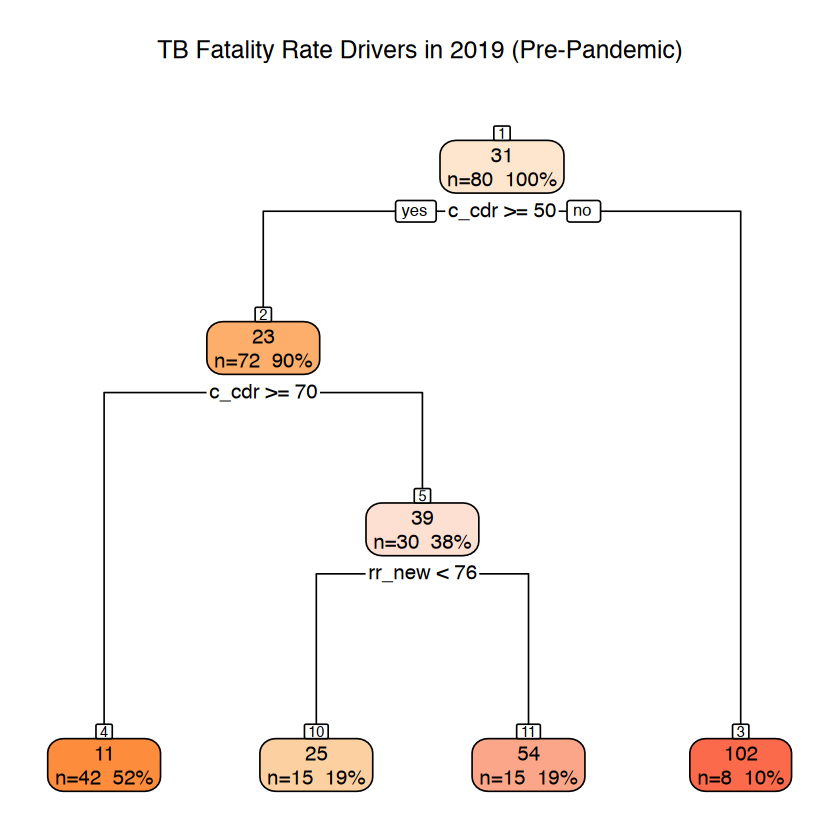

In [55]:
# Build the tree model for 2019
tree_2019 <- rpart(
  tree_formula, 
  data = data_2019,
  control = rpart.control(cp = 0.01)
)

# Plot the flowchart
rpart.plot(
  tree_2019,
  type = 2, extra = 101, box.palette = "OrRd", 
  nn = TRUE,
  main = "TB Fatality Rate Drivers in 2019 (Pre-Pandemic)"
)

Year 2020

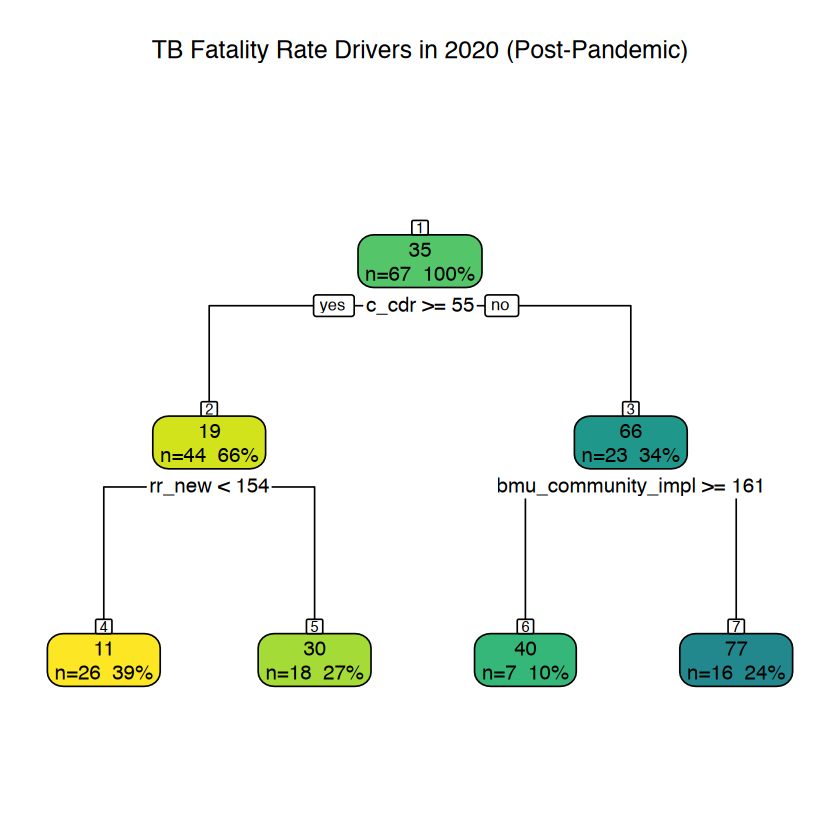

In [56]:
# Build the tree model for 2020
tree_2020 <- rpart(
  tree_formula, 
  data = data_2020,
  control = rpart.control(cp = 0.01)
)

# Plot the flowchart
rpart.plot(
  tree_2020,
  type = 2, extra = 101, box.palette = "YlGn",
  nn = TRUE,
  main = "TB Fatality Rate Drivers in 2020 (Post-Pandemic)"
)

Year 2021

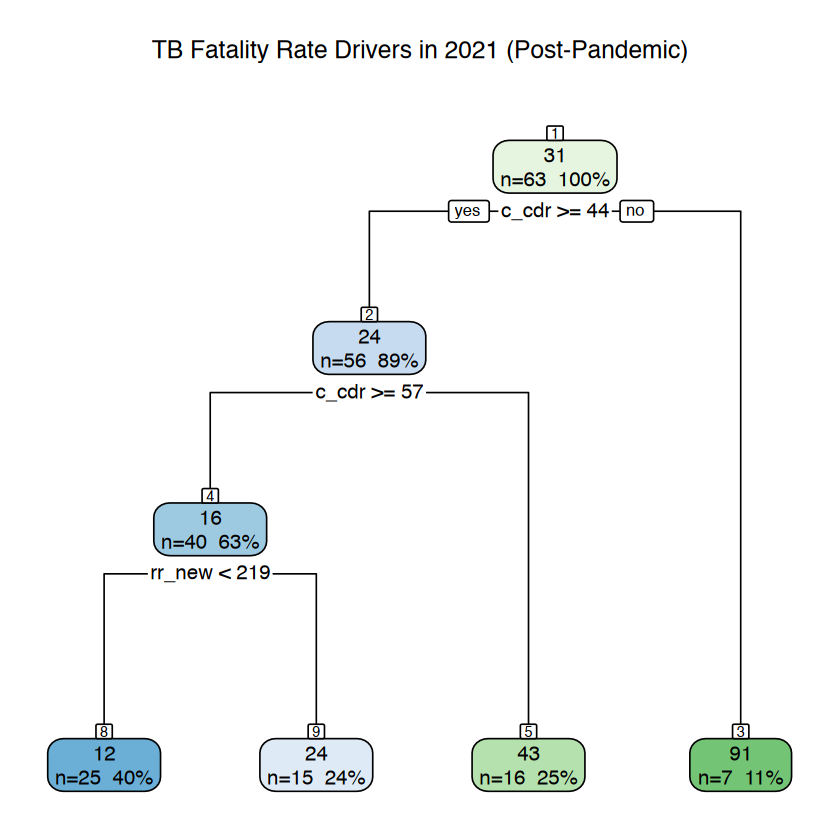

In [57]:
# Build the tree model for 2021
tree_2021 <- rpart(
  tree_formula, 
  data = data_2021,
  control = rpart.control(cp = 0.01)
)

# Plot the flowchart
rpart.plot(
  tree_2021,
  type = 2, extra = 101, box.palette = "BuGn",
  nn = TRUE,
  main = "TB Fatality Rate Drivers in 2021 (Post-Pandemic)"
)

Year 2022

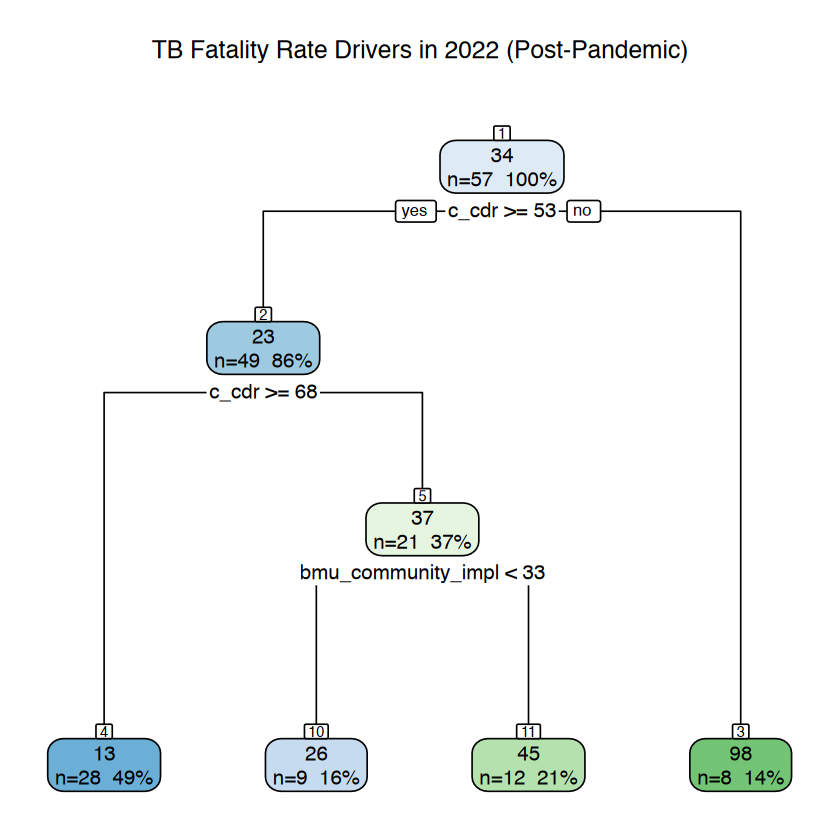

In [58]:
# Build the tree model for 2022
tree_2022 <- rpart(
  tree_formula, 
  data = data_2022,
  control = rpart.control(cp = 0.01)
)

# Plot the flowchart
rpart.plot(
  tree_2022,
  type = 2, extra = 101, box.palette = "BuGn",
  nn = TRUE,
  main = "TB Fatality Rate Drivers in 2022 (Post-Pandemic)"
)

Year 2023

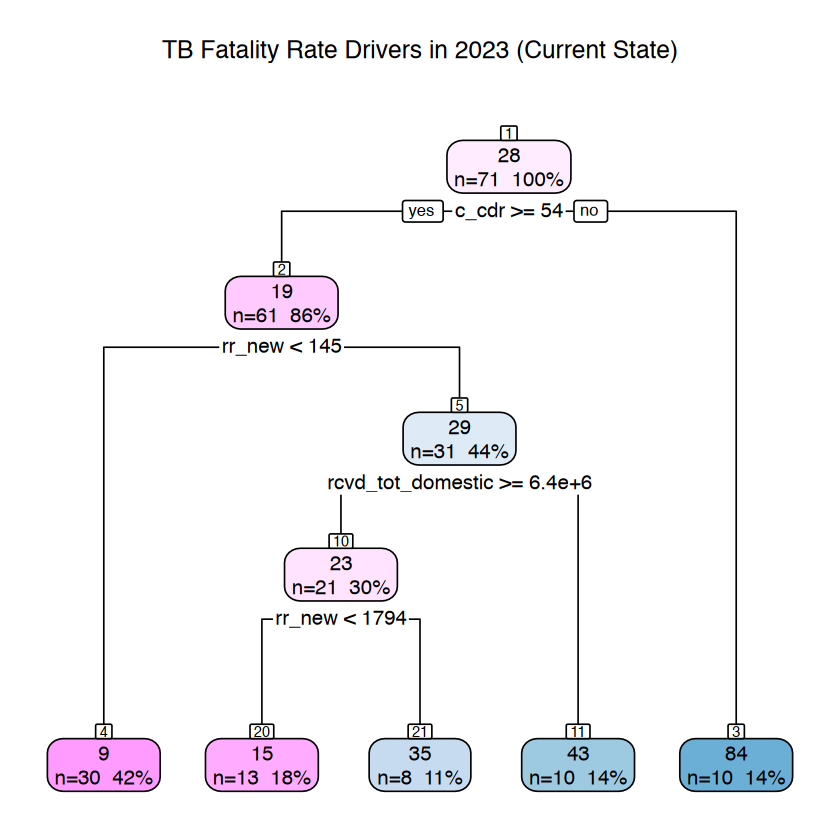

In [59]:
# Build the tree model for 2023
tree_2023 <- rpart(
  tree_formula, 
  data = data_2023,
  control = rpart.control(cp = 0.01)
)

# Plot the flowchart
rpart.plot(
  tree_2023,
  type = 2, extra = 101, box.palette = "PuBu",
  nn = TRUE,
  main = "TB Fatality Rate Drivers in 2023 (Current State)"
)

### 3.3 PCA

In [60]:
library(ggrepel) # For non-overlapping labels in plots

In [61]:
# 1. Define the variables that will define your "TB Profile"
# It's good to pick key outcome and input variables.
profile_vars <- c(
  'e_mort_100k',        # Case Mortality Rate
  'c_cdr',             # Case Detection Rate
  'rcvd_tot_domestic', # Domestic Funding
  'rr_new',             # Drug Resistance Burden
  'bmu_community_impl' # Community referral units
)

# 2. Prepare the 2018 data
data_2018 <- tb_clean %>%
  filter(year == 2018) %>%
  select(iso3, country, all_of(profile_vars)) %>%
  # drop_na() is crucial to get a complete dataset
  drop_na()

# 3. Scale the data (CRITICAL STEP)
# PCA and clustering are sensitive to the scale of variables. We must scale them
# so that a variable like 'rcvd_tot_domestic' (in millions) doesn't dominate
# a variable like 'cfr_country' (in percent).
data_2018_scaled <- data_2018 %>%
  # Keep iso3 and country for labeling later
  select(-iso3, -country) %>%
  # scale() centers and scales the data
  scale() %>%
  as_tibble()

# Add the country names back for plotting
data_2018_scaled$country <- data_2018$country
data_2018_scaled$iso3 <- data_2018$iso3

In [62]:
# Run the PCA on the scaled data (excluding identifier columns)
pca_result <- prcomp(
  data_2018_scaled %>% select(-country, -iso3), 
  center = TRUE, 
  scale. = TRUE
)

# Get the PCA scores (the coordinates for each country on the new dimensions)
pca_scores <- as_tibble(pca_result$x)
pca_scores$country <- data_2018$country
pca_scores$iso3 <- data_2018$iso3

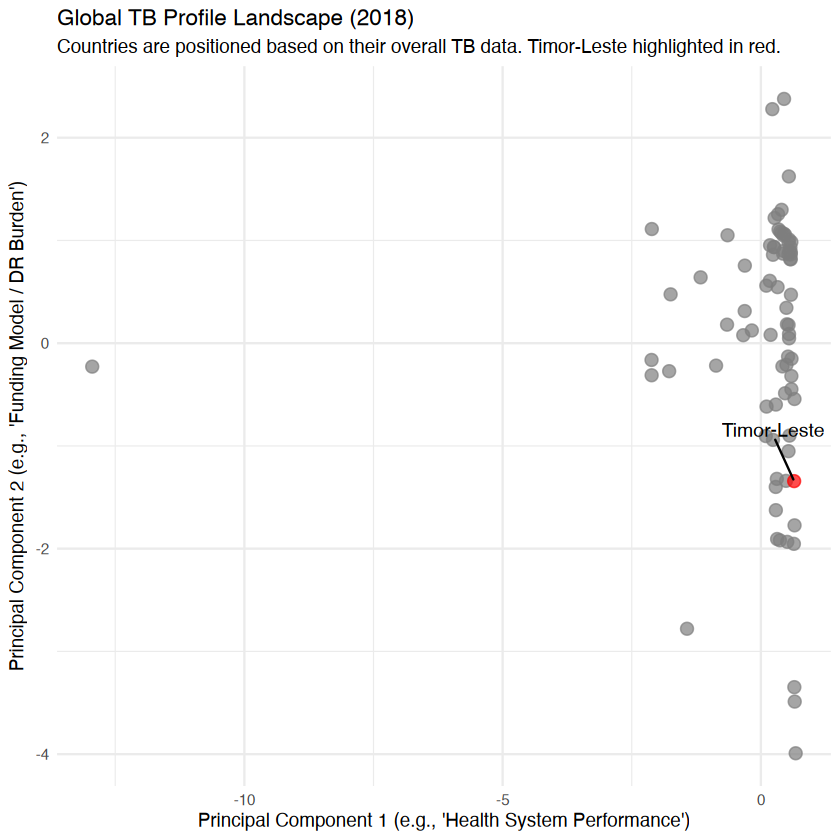

In [63]:
# Create a scatter plot of the first two principal components
ggplot(pca_scores, aes(x = PC1, y = PC2, label = country)) +
  geom_point(aes(color = iso3 == "TLS"), alpha = 0.7, size = 3) +
  geom_text_repel(
    data = subset(pca_scores, iso3 == "TLS"), # Label Timor-Leste
    size = 4, fontface = "bold", nudge_y = 0.5
  ) +
  scale_color_manual(values = c("TRUE" = "red", "FALSE" = "grey50"), guide = "none") +
  labs(
    title = "Global TB Profile Landscape (2018)",
    subtitle = "Countries are positioned based on their overall TB data. Timor-Leste highlighted in red.",
    x = "Principal Component 1 (e.g., 'Health System Performance')",
    y = "Principal Component 2 (e.g., 'Funding Model / DR Burden')"
  ) +
  theme_minimal()

### 3.4 Hierarchical clusterings

### For 2018 (pre-pandemic)

#### Step 1: Setup - Load Required Libraries

In [64]:
library(stats)
library(ggrepel) # For non-overlapping labels in plots

#### Step 2: Data Preparation

In [65]:
# 1. Prepare data (same as before)
profile_vars <- c(
  'e_mort_100k',        # Case Mortality Rate
  'c_cdr',             # Case Detection Rate
  'rcvd_tot_domestic', # Domestic Funding
  'rr_new',             # Drug Resistance Burden
  'bmu_community_impl' # Community referral units
)

data_for_clustering <- tb_clean %>%
  filter(year == 2018) %>%
  select(iso3, country, all_of(profile_vars)) %>%
  drop_na()

# Create the scaled data, but KEEP it as a matrix for now
data_scaled <- data_for_clustering %>%
  select(-iso3, -country) %>%
  scale()

# The plot function will use these names as labels.
rownames(data_scaled) <- data_for_clustering$country

In [66]:
data_for_clustering

iso3,country,e_mort_100k,c_cdr,rcvd_tot_domestic,rr_new,bmu_community_impl
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,29.0,70,551664,253,887
AGO,Angola,72.0,60,25830058,52,9
AZE,Azerbaijan,6.1,79,15349747,237,0
BGD,Bangladesh,29.0,74,13316019,782,480
BLR,Belarus,3.3,80,65878200,559,8
BEN,Benin,12.0,57,293256,8,76
BTN,Bhutan,16.0,80,57413,42,0
BOL,Bolivia (Plurinational State of),12.0,61,1023160,65,0
BIH,Bosnia and Herzegovina,3.0,79,2750285,2,17


#### Step 3: Build and Run the Models for various years

In [67]:
# 1. Calculate the "distance" between every pair of countries
# 'euclidean' is the standard, straight-line distance between points in space.
dist_matrix <- dist(data_scaled, method = 'euclidean')

# 2. Run the hierarchical clustering algorithm
# 'ward.D2' is a very effective method that tends to create compact, well-separated clusters.
hclust_result <- hclust(dist_matrix, method = 'ward.D2')

#### Step 4: Visualize and Interpret

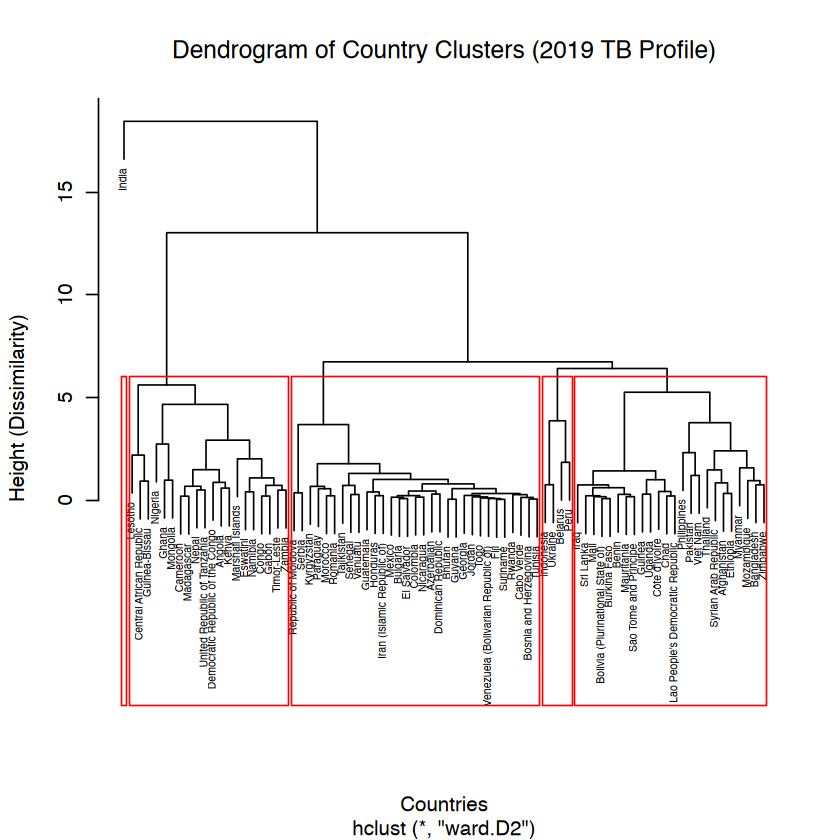

In [68]:
# Plot the dendrogram (the "family tree")
plot(
  hclust_result, 
  main = "Dendrogram of Country Clusters (2019 TB Profile)",
  xlab = "Countries",
  ylab = "Height (Dissimilarity)",
  cex = 0.5 # Adjust 'cex' to make country labels smaller or larger if they overlap
)

# Optional: Add boxes around the clusters to make them clearer
# Let's say we want to visualize 5 main clusters
rect.hclust(hclust_result, k = 5, border = "red")

### Step 5: Formally Identify Timor-Leste's Peer Group

In [69]:
# 1. "Cut" the tree to create a specific number of clusters.
# Choosing 'k' (the number of clusters) is part art, part science. 
# Look at the dendrogram to see what number makes sense. # Let's use k=5 as an example
clusters_vector <- cutree(hclust_result, k = 5)

# 2. Add the cluster assignments back to your original (unscaled) data
# This makes it easy to inspect the characteristics of each cluster.
data_with_clusters <- data_for_clustering %>%
  mutate(cluster = clusters_vector)

# 3. Find Timor-Leste's cluster number
# Use its ISO code for accuracy
timor_cluster_number <- data_with_clusters %>%
  filter(iso3 == "TLS") %>%
  pull(cluster)

# 4. Filter the data to get the list of all countries in Timor-Leste's peer group
peer_group <- data_with_clusters %>%
  filter(cluster == timor_cluster_number)

# 5. Print the final result
cat("Timor-Leste belongs to Cluster #", timor_cluster_number, "\n")
cat("The countries in this peer group are:\n")
print(peer_group)

# Optional: Calculate the average profile for this cluster
cluster_profile <- peer_group %>%
  summarise(across(all_of(profile_vars), mean, na.rm = TRUE))

cat("\nAverage profile for this cluster:\n")
print(cluster_profile)

Timor-Leste belongs to Cluster # 2 
The countries in this peer group are:
# A tibble: 20 x 8
   iso3  country   e_mort_100k c_cdr rcvd_tot_domestic rr_new bmu_community_impl
   <fct> <fct>           <dbl> <dbl>             <dbl>  <dbl>              <dbl>
 1 AGO   Angola             72    60          25830058     52                  9
 2 CMR   Cameroon           53    51            778723    106                 36
 3 CAF   Central ~         169    41            761742      4                 80
 4 COG   Congo             101    52            113809     21                  2
 5 COD   Democrat~          64    59            551800    314                517
 6 SWZ   Eswatini          127    58           1738295    119                130
 7 GAB   Gabon             104    49            421711     43                  1
 8 GHA   Ghana              52    31           3011486     95                216
 9 GNB   Guinea-B~         145    29            321965     45                 20
10 KEN   Kenya  

Warning message:
"There was 1 warning in `summarise()`.
i In argument: `across(all_of(profile_vars), mean, na.rm = TRUE)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"



Average profile for this cluster:
# A tibble: 1 x 5
  e_mort_100k c_cdr rcvd_tot_domestic rr_new bmu_community_impl
        <dbl> <dbl>             <dbl>  <dbl>              <dbl>
1        93.8    50          6007117.   236.               131.


### For 2020 (post-pandemic)

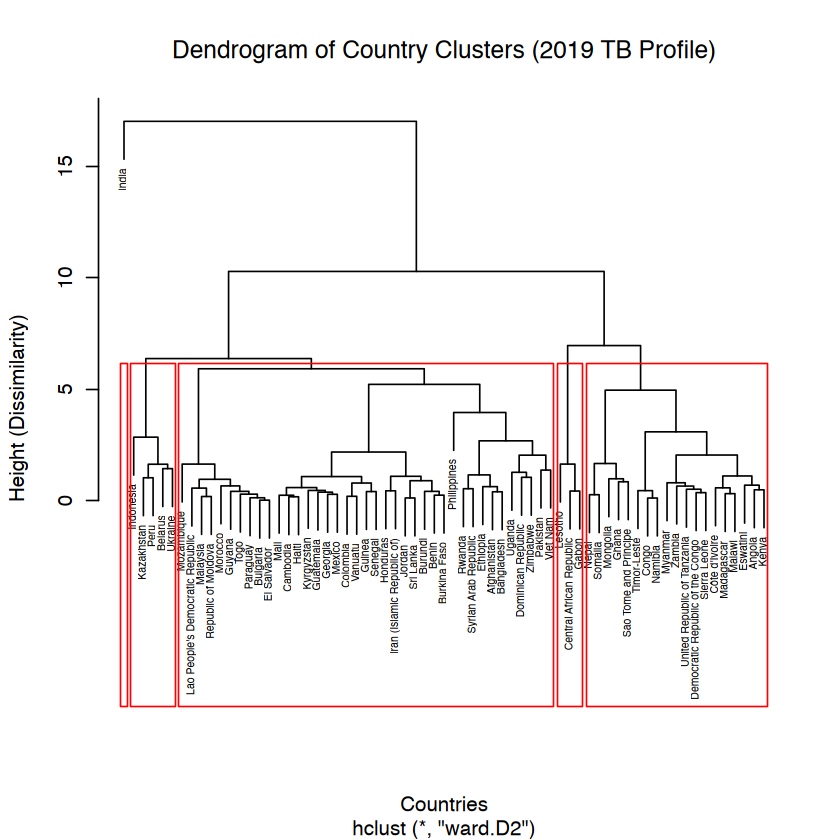

In [70]:
# 1. Prepare data (same as before)
profile_vars <- c(
  'e_mort_100k',        # Case Mortality Rate
  'c_cdr',             # Case Detection Rate
  'rcvd_tot_domestic', # Domestic Funding
  'rr_new',             # Drug Resistance Burden
  'bmu_community_impl' # Community referral units
)

data_for_clustering <- tb_clean %>%
  filter(year == 2020) %>%
  select(iso3, country, all_of(profile_vars)) %>%
  drop_na()

# Create the scaled data, but KEEP it as a matrix for now
data_scaled <- data_for_clustering %>%
  select(-iso3, -country) %>%
  scale()

# The plot function will use these names as labels.
rownames(data_scaled) <- data_for_clustering$country

# 1. Calculate the "distance" between every pair of countries
# 'euclidean' is the standard, straight-line distance between points in space.
dist_matrix <- dist(data_scaled, method = 'euclidean')

# 2. Run the hierarchical clustering algorithm
# 'ward.D2' is a very effective method that tends to create compact, well-separated clusters.
hclust_result <- hclust(dist_matrix, method = 'ward.D2')

# Plot the dendrogram (the "family tree")
plot(
  hclust_result, 
  main = "Dendrogram of Country Clusters (2019 TB Profile)",
  xlab = "Countries",
  ylab = "Height (Dissimilarity)",
  cex = 0.5 # Adjust 'cex' to make country labels smaller or larger if they overlap
)

# Optional: Add boxes around the clusters to make them clearer
# Let's say we want to visualize 5 main clusters
rect.hclust(hclust_result, k = 5, border = "red")


In [71]:
# 1. "Cut" the tree to create a specific number of clusters.
# Choosing 'k' (the number of clusters) is part art, part science. 
# Look at the dendrogram to see what number makes sense. # Let's use k=5 as an example
clusters_vector <- cutree(hclust_result, k = 5)

# 2. Add the cluster assignments back to your original (unscaled) data
# This makes it easy to inspect the characteristics of each cluster.
data_with_clusters <- data_for_clustering %>%
  mutate(cluster = clusters_vector)

# 3. Find Timor-Leste's cluster number
# Use its ISO code for accuracy
timor_cluster_number <- data_with_clusters %>%
  filter(iso3 == "TLS") %>%
  pull(cluster)

# 4. Filter the data to get the list of all countries in Timor-Leste's peer group
peer_group <- data_with_clusters %>%
  filter(cluster == timor_cluster_number)

# 5. Print the final result
cat("Timor-Leste belongs to Cluster #", timor_cluster_number, "\n")
cat("The countries in this peer group are:\n")
print(peer_group)

# Optional: Calculate the average profile for this cluster
cluster_profile <- peer_group %>%
  summarise(across(all_of(profile_vars), mean, na.rm = TRUE))

cat("\nAverage profile for this cluster:\n")
print(cluster_profile)

Timor-Leste belongs to Cluster # 2 
The countries in this peer group are:
# A tibble: 19 x 8
   iso3  country   e_mort_100k c_cdr rcvd_tot_domestic rr_new bmu_community_impl
   <fct> <fct>           <dbl> <dbl>             <dbl>  <dbl>              <dbl>
 1 AGO   "Angola"           62    58           5373932    250                  0
 2 COG   "Congo"           105    52            154516    163                  2
 3 CIV   "C\u00f4~          34    51           3530450    124                320
 4 COD   "Democra~          57    66           1070910    455                399
 5 SWZ   "Eswatin~          83    53           1331704     43                130
 6 GHA   "Ghana"            51    28           1582000    180                260
 7 KEN   "Kenya"            60    54          13664832    285                290
 8 MDG   "Madagas~          51    54                 0      6                120
 9 MWI   "Malawi"           40    56            971307     42                 28
10 MNG   "Mongol

### 3.5 Multivariate Linear Regression (per year)

In [72]:
# Load the libraries
library(tidyverse)
library(modelsummary)

### 2018

In [73]:
# 1. Filter the main 'tb_clean' tibble for the year 2019
data_SEA_2018 <- tb_clean %>%
  filter(year == 2018) %>%
  filter(g_whoregion == "SEA")

data_AFR_2018 <- tb_clean %>%
  filter(year == 2018) %>%
  filter(g_whoregion == "AFR")

# 2. Select the variables for the model and remove rows with missing data
# This ensures the model runs on a complete dataset for that year.
model_data_SEA_2018 <- data_SEA_2018 %>%
  select(
    # Target variable (Y)
    e_mort_100k,
    
    # Predictor variables (X)
    c_cdr,
    rcvd_tot_domestic,
    rr_new,
    bmu_community_impl
  ) %>%
  # drop_na() is essential for lm() to work correctly
  drop_na()

model_data_AFR_2018 <- data_AFR_2018 %>%
  select(
    # Target variable (Y)
    e_mort_100k,
    
    # Predictor variables (X)
    c_cdr,
    rcvd_tot_domestic,
    rr_new,
    bmu_community_impl
  ) %>%
  # drop_na() is essential for lm() to work correctly
  drop_na()

In [74]:
# 1. Define the model formula
# This is the same structure as before, linking the target to the predictors.
lm_formula <- e_mort_100k ~ c_cdr + rcvd_tot_domestic + rr_new + bmu_community_impl

# 2. Run the linear model on the 2019 data
# We use lm() because this is a standard cross-sectional regression, not a panel model.
lm_2018_SEA_model <- lm(lm_formula, data = model_data_SEA_2018)
lm_2018_AFR_model <- lm(lm_formula, data = model_data_AFR_2018)

In [75]:
summary(lm_2018_SEA_model)
summary(lm_2018_AFR_model)


Call:
lm(formula = lm_formula, data = model_data_SEA_2018)

Residuals:
       1        2        3        4        5        6        7        8 
  0.5123   2.2332   2.5263  -7.5377   8.8215  -5.7688 -39.0076 -12.0721 
       9 
 50.2931 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)
(Intercept)         1.414e+02  8.938e+01   1.582    0.189
c_cdr              -1.599e+00  1.398e+00  -1.144    0.317
rcvd_tot_domestic  -4.578e-07  9.495e-07  -0.482    0.655
rr_new              8.439e-03  1.566e-02   0.539    0.619
bmu_community_impl  1.031e-02  3.490e-02   0.296    0.782

Residual standard error: 33.08 on 4 degrees of freedom
Multiple R-squared:  0.3008,	Adjusted R-squared:  -0.3985 
F-statistic: 0.4301 on 4 and 4 DF,  p-value: 0.7831



Call:
lm(formula = lm_formula, data = model_data_AFR_2018)

Residuals:
   Min     1Q Median     3Q    Max 
-57.15 -29.74  -8.83  22.87 147.78 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.754e+02  3.818e+01   4.594 9.06e-05 ***
c_cdr              -1.898e+00  6.193e-01  -3.064  0.00491 ** 
rcvd_tot_domestic   6.575e-07  1.457e-06   0.451  0.65532    
rr_new              3.887e-03  3.385e-02   0.115  0.90942    
bmu_community_impl -4.543e-02  5.163e-02  -0.880  0.38675    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 47.71 on 27 degrees of freedom
Multiple R-squared:  0.3115,	Adjusted R-squared:  0.2095 
F-statistic: 3.054 on 4 and 27 DF,  p-value: 0.03374


In [76]:
# Create a professional summary table of the regression results
modelsummary(
  lm_2018_SEA_model,
  title = "TB Mortality Drivers in 2018 (SEA Region)",
  stars = TRUE,
  gof_map = c("nobs", "r.squared") # We can select which goodness-of-fit stats to show
)

modelsummary(
  lm_2018_AFR_model,
  title = "TB Mortality Drivers in 2018 (AFR Region)",
  stars = TRUE,
  gof_map = c("nobs", "r.squared") # We can select which goodness-of-fit stats to show
)


+--------------------+----------+
|                    | (1)      |
+====================+==========+
| (Intercept)        | 141.364  |
+--------------------+----------+
|                    | (89.384) |
+--------------------+----------+
| c_cdr              | -1.599   |
+--------------------+----------+
|                    | (1.398)  |
+--------------------+----------+
| rcvd_tot_domestic  | -0.000   |
+--------------------+----------+
|                    | (0.000)  |
+--------------------+----------+
| rr_new             | 0.008    |
+--------------------+----------+
|                    | (0.016)  |
+--------------------+----------+
| bmu_community_impl | 0.010    |
+--------------------+----------+
|                    | (0.035)  |
+--------------------+----------+
| Num.Obs.           | 9        |
+--------------------+----------+
| R2                 | 0.301    |
+====================+==========+
| + p < 0.1, * p < 0.05, ** p   |
| < 0.01, *** p < 0.001         |
+============


+--------------------+------------+
|                    | (1)        |
+====================+============+
| (Intercept)        | 175.435*** |
+--------------------+------------+
|                    | (38.185)   |
+--------------------+------------+
| c_cdr              | -1.898**   |
+--------------------+------------+
|                    | (0.619)    |
+--------------------+------------+
| rcvd_tot_domestic  | 0.000      |
+--------------------+------------+
|                    | (0.000)    |
+--------------------+------------+
| rr_new             | 0.004      |
+--------------------+------------+
|                    | (0.034)    |
+--------------------+------------+
| bmu_community_impl | -0.045     |
+--------------------+------------+
|                    | (0.052)    |
+--------------------+------------+
| Num.Obs.           | 32         |
+--------------------+------------+
| R2                 | 0.312      |
+====================+============+
| + p < 0.1, * p < 0.05, **

### 2023

In [77]:
# 1. Filter the main 'tb_clean' tibble for the year 2019
data_SEA_2023 <- tb_clean %>%
  filter(year == 2023) %>%
  filter(g_whoregion == "SEA")

data_AFR_2023 <- tb_clean %>%
  filter(year == 2023) %>%
  filter(g_whoregion == "AFR")

# 2. Select the variables for the model and remove rows with missing data
# This ensures the model runs on a complete dataset for that year.
model_data_SEA_2023 <- data_SEA_2023 %>%
  select(
    # Target variable (Y)
    e_mort_100k,
    
    # Predictor variables (X)
    c_cdr,
    rcvd_tot_domestic,
    rr_new,
    bmu_community_impl
  ) %>%
  # drop_na() is essential for lm() to work correctly
  drop_na()

model_data_AFR_2023 <- data_AFR_2023 %>%
  select(
    # Target variable (Y)
    e_mort_100k,
    
    # Predictor variables (X)
    c_cdr,
    rcvd_tot_domestic,
    rr_new,
    bmu_community_impl
  ) %>%
  # drop_na() is essential for lm() to work correctly
  drop_na()

In [78]:
# 1. Define the model formula
# This is the same structure as before, linking the target to the predictors.
lm_formula <- e_mort_100k ~ c_cdr + rcvd_tot_domestic + rr_new + bmu_community_impl

# 2. Run the linear model on the 2019 data
# We use lm() because this is a standard cross-sectional regression, not a panel model.
lm_2023_SEA_model <- lm(lm_formula, data = model_data_SEA_2023)
lm_2023_AFR_model <- lm(lm_formula, data = model_data_AFR_2023)

In [79]:
summary(lm_2023_SEA_model)
summary(lm_2023_AFR_model)


Call:
lm(formula = lm_formula, data = model_data_SEA_2023)

Residuals:
      1       2       3       4       5       6       7 
13.5035 -0.2768 -2.8037  9.4908 -8.2304 -2.7634 -8.9200 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)  
(Intercept)         2.611e+02  5.866e+01   4.452   0.0469 *
c_cdr              -3.964e+00  1.098e+00  -3.610   0.0689 .
rcvd_tot_domestic   2.908e-06  1.252e-06   2.323   0.1458  
rr_new             -1.865e-02  1.018e-02  -1.831   0.2085  
bmu_community_impl  1.222e-03  1.237e-02   0.099   0.9303  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.75 on 2 degrees of freedom
Multiple R-squared:  0.9132,	Adjusted R-squared:  0.7397 
F-statistic: 5.262 on 4 and 2 DF,  p-value: 0.166



Call:
lm(formula = lm_formula, data = model_data_AFR_2023)

Residuals:
   Min     1Q Median     3Q    Max 
-47.07 -23.45  -5.98  17.90  76.56 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.353e+02  2.579e+01   5.248 1.56e-05 ***
c_cdr              -1.312e+00  3.378e-01  -3.884  0.00060 ***
rcvd_tot_domestic   3.596e-06  1.102e-06   3.263  0.00298 ** 
rr_new             -2.488e-02  1.219e-02  -2.041  0.05118 .  
bmu_community_impl -1.190e-02  1.878e-02  -0.634  0.53155    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 35.24 on 27 degrees of freedom
Multiple R-squared:  0.5602,	Adjusted R-squared:  0.4951 
F-statistic:   8.6 on 4 and 27 DF,  p-value: 0.0001306


In [80]:
# Create a professional summary table of the regression results
modelsummary(
  lm_2023_SEA_model,
  title = "TB Mortality Drivers in 2023 (SEA Region)",
  stars = TRUE,
  gof_map = c("nobs", "r.squared") # We can select which goodness-of-fit stats to show
)

modelsummary(
  lm_2023_AFR_model,
  title = "TB Mortality Drivers in 2023 (AFR Region)",
  stars = TRUE,
  gof_map = c("nobs", "r.squared") # We can select which goodness-of-fit stats to show
)


+--------------------+----------+
|                    | (1)      |
+====================+==========+
| (Intercept)        | 261.139* |
+--------------------+----------+
|                    | (58.660) |
+--------------------+----------+
| c_cdr              | -3.964+  |
+--------------------+----------+
|                    | (1.098)  |
+--------------------+----------+
| rcvd_tot_domestic  | 0.000    |
+--------------------+----------+
|                    | (0.000)  |
+--------------------+----------+
| rr_new             | -0.019   |
+--------------------+----------+
|                    | (0.010)  |
+--------------------+----------+
| bmu_community_impl | 0.001    |
+--------------------+----------+
|                    | (0.012)  |
+--------------------+----------+
| Num.Obs.           | 7        |
+--------------------+----------+
| R2                 | 0.913    |
+====================+==========+
| + p < 0.1, * p < 0.05, ** p   |
| < 0.01, *** p < 0.001         |
+============


+--------------------+------------+
|                    | (1)        |
+====================+============+
| (Intercept)        | 135.340*** |
+--------------------+------------+
|                    | (25.788)   |
+--------------------+------------+
| c_cdr              | -1.312***  |
+--------------------+------------+
|                    | (0.338)    |
+--------------------+------------+
| rcvd_tot_domestic  | 0.000**    |
+--------------------+------------+
|                    | (0.000)    |
+--------------------+------------+
| rr_new             | -0.025+    |
+--------------------+------------+
|                    | (0.012)    |
+--------------------+------------+
| bmu_community_impl | -0.012     |
+--------------------+------------+
|                    | (0.019)    |
+--------------------+------------+
| Num.Obs.           | 32         |
+--------------------+------------+
| R2                 | 0.560      |
+====================+============+
| + p < 0.1, * p < 0.05, **